<a href="https://colab.research.google.com/github/lucasinanaj/TimeSeriesAnalysis/blob/main/TSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The train.csv file contains three fields

date: string with date in format yyyy-mm-dd;
weekday: string with the name of the weekday;
ave_days: floating point number representing the average number of days needed to close the requests that were closed that day.
The train set starts on 2007-01-04 and ends on 2015-03-31.

Objectives of the project:
You have to provide forecasts for all the days from 2015-04-01 through 2015-11-07.
You must produce three sequences of forecasts using an ARIMA, a UCM, and a Machine Learning (ML) model.
You have to load your predictions using the assignment tool below. I will produce a ranking of your forecasts based on the MAE, which I will periodically update.
The format of the CSV file with your forecasts is the following. There must be four fields:
date - as in the train file
ARIMA - forecasts produced with an ARIMA
UCM  - forecasts produced with a UCM
ML  - forecasts produced with an ML
The prediction CSV files must be named matricola_yyyymmdd.csv (for example 123456_20240101.csv), where the date refers to the submission day.
In the project, you should try different models for every class and carry out validation processes to select the most promising one in each class.
The model selection processes should be treated in the report you will write and discuss during the exam.

# Libraries and data import

In [ ]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import scipy.stats as stats
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import rpy2

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/TSA/train_2324.csv"
data = pd.read_csv(path)

# Data Exploration

In [ ]:
data.head()

date   weekday  ave_days
0  2007-01-04  Thursday  0.179487
1  2007-01-05    Friday  0.500000
2  2007-01-06  Saturday       NaN
3  2007-01-07    Sunday       NaN
4  2007-01-08    Monday  3.521739

In [ ]:
data = data.rename(columns = {'ave_days':'Value'}, inplace = False)

## Null or duplicates

In [ ]:
print(data['Value'].isnull())

0       False
1       False
2        True
3        True
4       False
        ...  
3004    False
3005    False
3006    False
3007    False
3008    False
Name: Value, Length: 3009, dtype: bool


In [ ]:
print(data.isnull().sum())

date         0
weekday      0
Value      202
dtype: int64


In [ ]:
print(sum(data.duplicated()))

0


In [ ]:
# Creazione di un filtro per le righe in cui il valore 'value' è nullo
null_values = data[data['Value'].isnull()]

# Conteggio delle righe in cui i valori nulli in 'value' corrispondono a 'Saturday' o 'Sunday' in 'weekday'
count_weekend_null_values = null_values[(null_values['weekday'] == 'Saturday') | (null_values['weekday'] == 'Sunday')].shape[0]

# Verifica se i valori nulli in 'value' corrispondono sempre a 'Saturday' o 'Sunday' in 'weekday'
if count_weekend_null_values == null_values.shape[0]:
    print("I valori nulli in 'value' coincidono sempre con 'Saturday' o 'Sunday' in 'weekday'.")
else:
    print("I valori nulli in 'value' non coincidono sempre con 'Saturday' o 'Sunday' in 'weekday'.")

I valori nulli in 'value' non coincidono sempre con 'Saturday' o 'Sunday' in 'weekday'.


In [ ]:
nan_distribution = data[data['Value'].isnull()].groupby('weekday').size()

print(nan_distribution)

Series([], dtype: int64)


In [ ]:
# We choose 1 as default value for Nan Values
data['Value'] = data['Value'].fillna(1)

In [ ]:
# data = data.dropna()

## Types and data adjustments

In [ ]:
data.dtypes

weekday              object
Value               float64
Year                  int64
Month                 int64
Day                   int64
Month_Name           object
Num_DayofYear         int64
Num_DayofWeek         int64
Num_WeekofYear       UInt32
Quarter               int64
Just_Date            object
Is_Sunday             int64
Is_Christmas          int64
Is_Easter             int64
Is_Last_of_Year       int64
Is_Aug_15             int64
Value_Log           float64
Winsorized_Value    float64
dtype: object

In [ ]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data.head()

date   weekday     Value
0 2007-01-04  Thursday  0.179487
1 2007-01-05    Friday  0.500000
2 2007-01-06  Saturday  1.000000
3 2007-01-07    Sunday  1.000000
4 2007-01-08    Monday  3.521739

In [ ]:
data['Year'] = data.date.dt.year
data['Month'] = data.date.dt.month
data['Day'] = data.date.dt.day
data['Month_Name'] = data.date.dt.strftime("%B")

data['Num_DayofYear'] = data['date'].dt.dayofyear
data['Num_DayofWeek'] = data['date'].dt.dayofweek
data['Num_WeekofYear'] = data['date'].dt.isocalendar().week

data['Quarter'] = data['date'].dt.quarter

data['Just_Date'] = data['date'].dt.date

In [ ]:
data.head()

date   weekday     Value  Year  Month  Day Month_Name  Num_DayofYear  \
0 2007-01-04  Thursday  0.179487  2007      1    4    January              4   
1 2007-01-05    Friday  0.500000  2007      1    5    January              5   
2 2007-01-06  Saturday  1.000000  2007      1    6    January              6   
3 2007-01-07    Sunday  1.000000  2007      1    7    January              7   
4 2007-01-08    Monday  3.521739  2007      1    8    January              8   

   Num_DayofWeek  Num_WeekofYear  Quarter   Just_Date  
0              3               1        1  2007-01-04  
1              4               1        1  2007-01-05  
2              5               1        1  2007-01-06  
3              6               1        1  2007-01-07  
4              0               2        1  2007-01-08

## Set date as index

In [ ]:
data.set_index(data['date'], inplace = True)

In [ ]:
data = data.drop(['date'], axis = 1)

In [ ]:
print(data)

             weekday      Value  Year  Month  Day Month_Name  Num_DayofYear  \
date                                                                          
2007-01-04  Thursday   0.179487  2007      1    4    January              4   
2007-01-05    Friday   0.500000  2007      1    5    January              5   
2007-01-06  Saturday   1.000000  2007      1    6    January              6   
2007-01-07    Sunday   1.000000  2007      1    7    January              7   
2007-01-08    Monday   3.521739  2007      1    8    January              8   
...              ...        ...   ...    ...  ...        ...            ...   
2015-03-27    Friday  38.580756  2015      3   27      March             86   
2015-03-28  Saturday   1.040000  2015      3   28      March             87   
2015-03-29    Sunday  42.000000  2015      3   29      March             88   
2015-03-30    Monday  63.477124  2015      3   30      March             89   
2015-03-31   Tuesday  40.496689  2015      3   31   

## Holidays and sundays dummy

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming your time series data is stored in a DataFrame called df
# and 'date' column is already in datetime format

# Create dummy columns for holidays
data['Is_Sunday'] = (data['Num_DayofWeek'] == 6).astype(int)

# Christmas (December 25th)
data['Is_Christmas'] = ((data['Month'] == 12) & (data['Day'] == 25)).astype(int)
data['Is_Christmas'] = ((data['Month'] == 12) & (data['Day'] == 24)).astype(int)
data['Is_Christmas'] = ((data['Month'] == 12) & (data['Day'] == 26)).astype(int)

# Easter (This is a simplified example, actual calculation might be more complex)
# Easter is usually the first Sunday after the first full moon after March 21st
# You may need to use a library or a more detailed calculation for accurate results
data['Is_Easter'] = ((data['Month'] == 3) & (data['Day'] >= 21) & (data['Num_DayofWeek'] == 6)).astype(int)

# Last day of the year (December 31st)
data['Is_Last_of_Year'] = ((data['Month'] == 12) & (data['Day'] == 31)).astype(int)

# August 15th
data['Is_Aug_15'] = ((data['Month'] == 8) & (data['Day'] == 15)).astype(int)

# Print the DataFrame to check the new columns
print(data)


             weekday      Value  Year  Month  Day Month_Name  Num_DayofYear  \
date                                                                          
2007-01-04  Thursday   0.179487  2007      1    4    January              4   
2007-01-05    Friday   0.500000  2007      1    5    January              5   
2007-01-06  Saturday   1.000000  2007      1    6    January              6   
2007-01-07    Sunday   1.000000  2007      1    7    January              7   
2007-01-08    Monday   3.521739  2007      1    8    January              8   
...              ...        ...   ...    ...  ...        ...            ...   
2015-03-27    Friday  38.580756  2015      3   27      March             86   
2015-03-28  Saturday   1.040000  2015      3   28      March             87   
2015-03-29    Sunday  42.000000  2015      3   29      March             88   
2015-03-30    Monday  63.477124  2015      3   30      March             89   
2015-03-31   Tuesday  40.496689  2015      3   31   

# Explorative anlayses

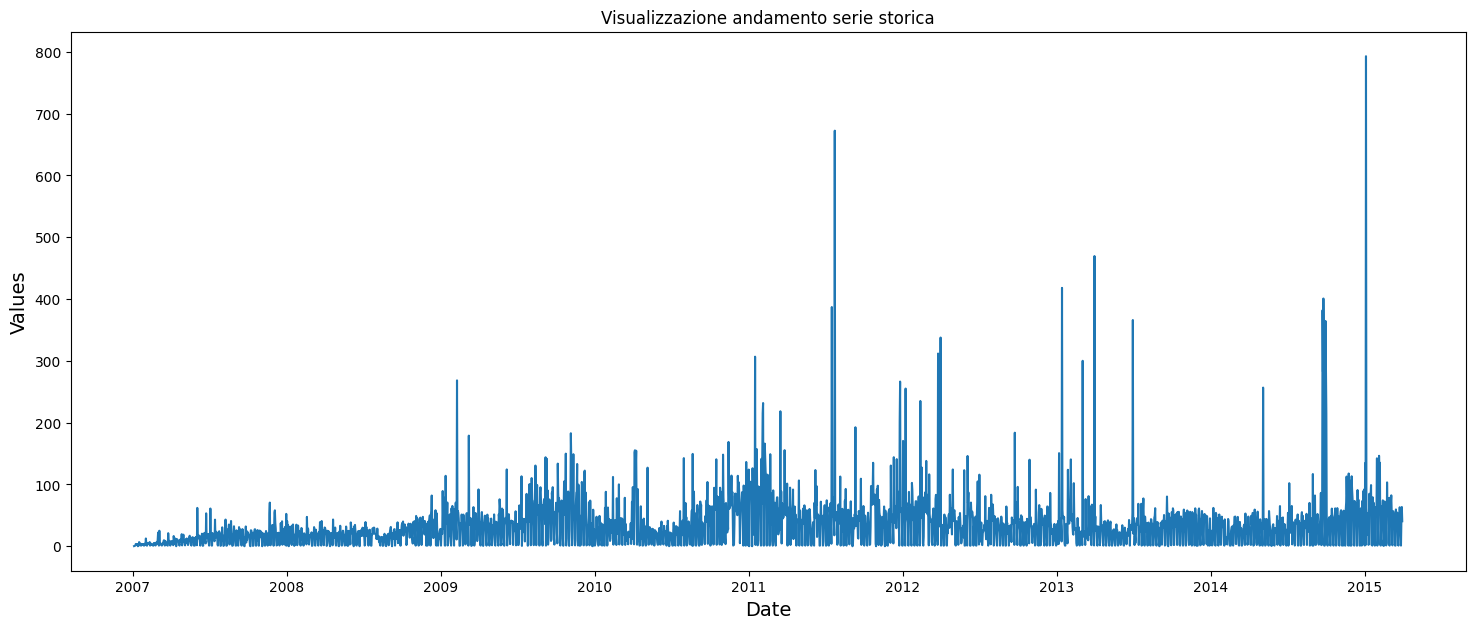

In [ ]:
#Plot time series with day granularity
figure(figsize=(18, 7), dpi=100, linewidth=10)
plt.plot(data['Just_Date'], data['Value'])
plt.title('Visualizzazione andamento serie storica')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.show()

At first sight we can notice a large number of outlier values

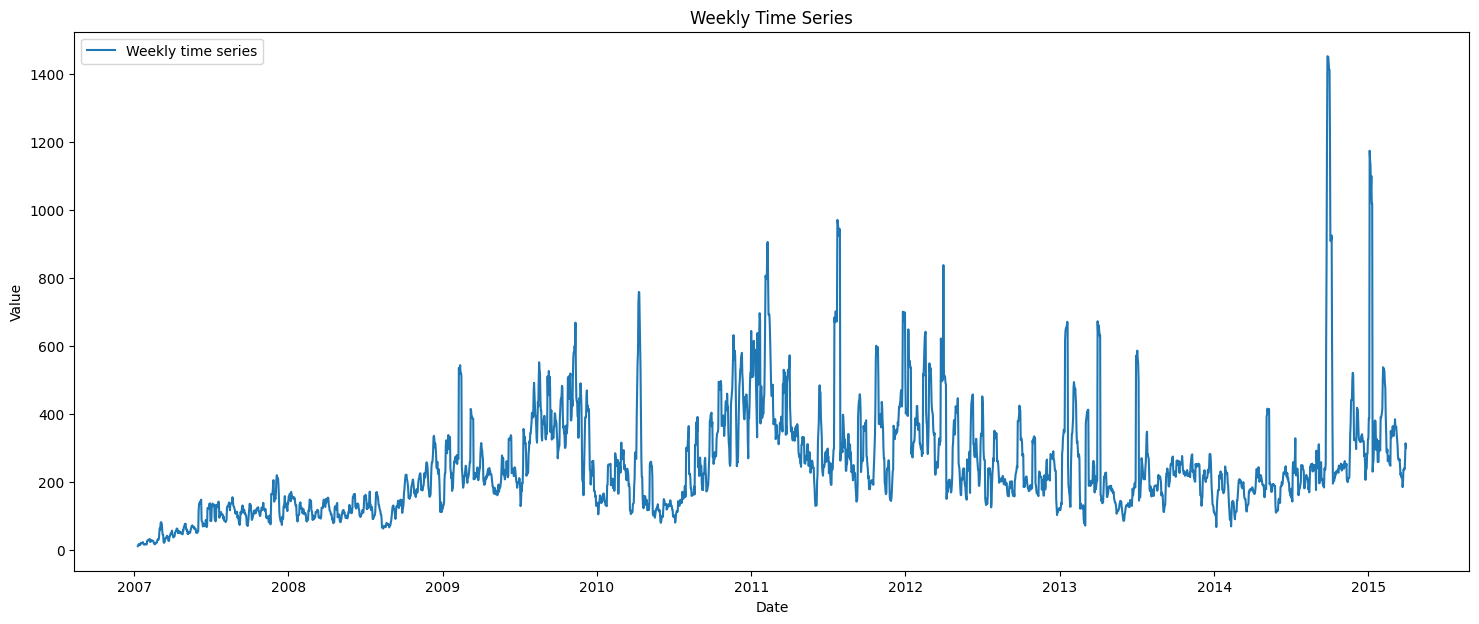

In [ ]:
# Weekly rolling avarage
serie_sett = data['Value'].rolling(window=7).sum()

# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_sett, label="Weekly time series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Weekly Time Series")
plt.legend()
plt.show()

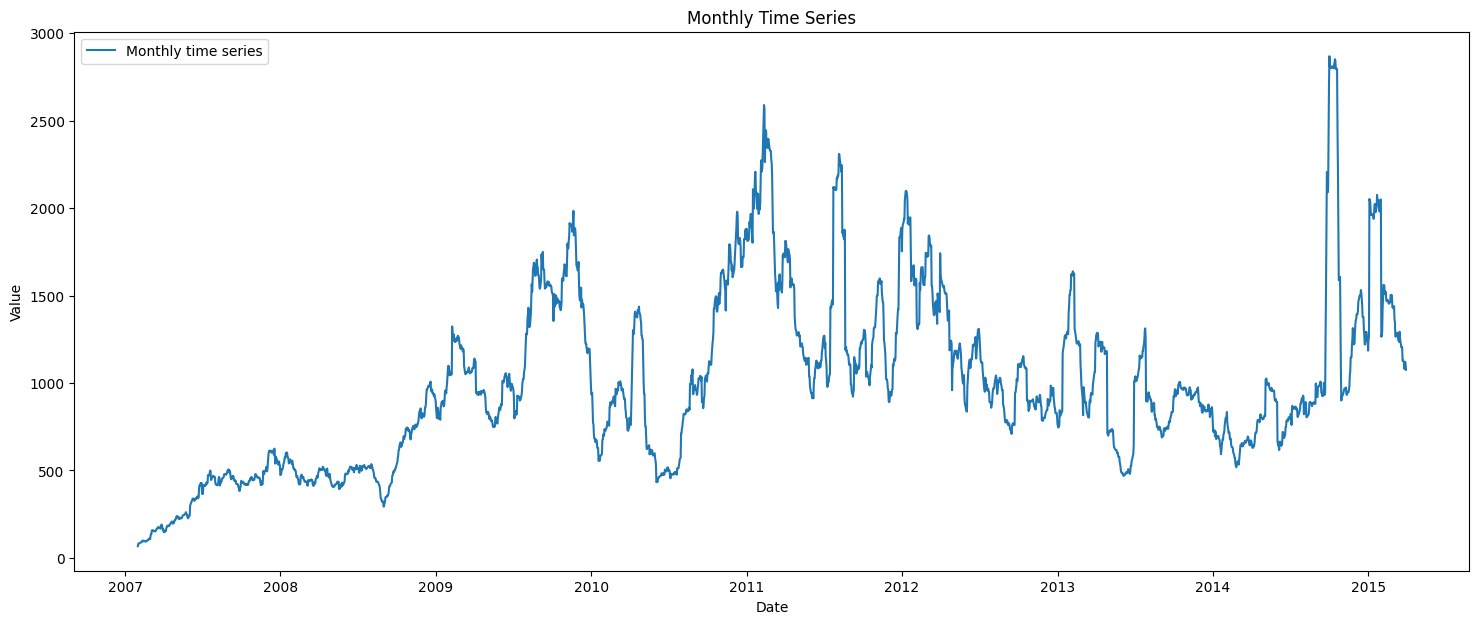

In [ ]:
# Weekly rolling avarage
serie_sett = data['Value'].rolling(window=28).sum() # 28 = 7 x 4 (4 weeks in a month)

# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_sett, label="Monthly time series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Monthly Time Series")
plt.legend()
plt.show()

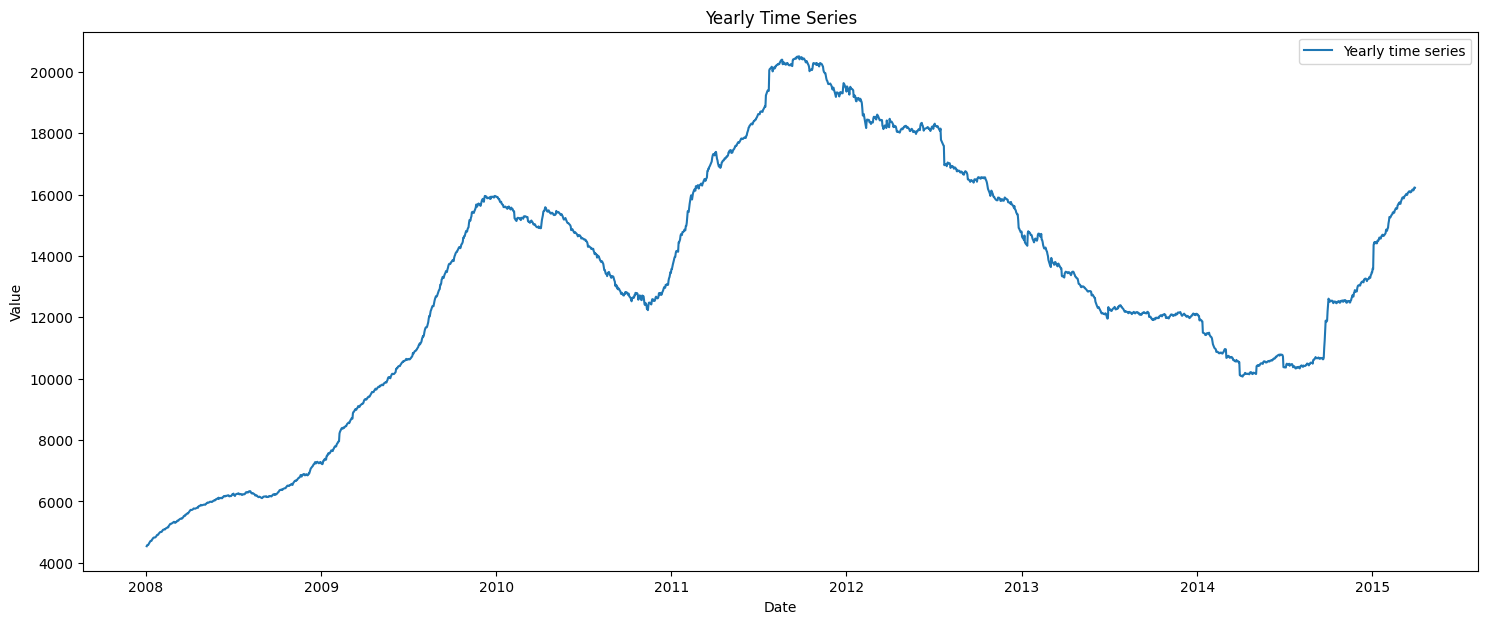

In [ ]:
# Yearly rolling avarage
serie_sett = data['Value'].rolling(window=365).sum() # 28 = 7 x 4 (4 weeks in a month)

# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_sett, label="Yearly time series")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Yearly Time Series")
plt.legend()
plt.show()

## Box plot

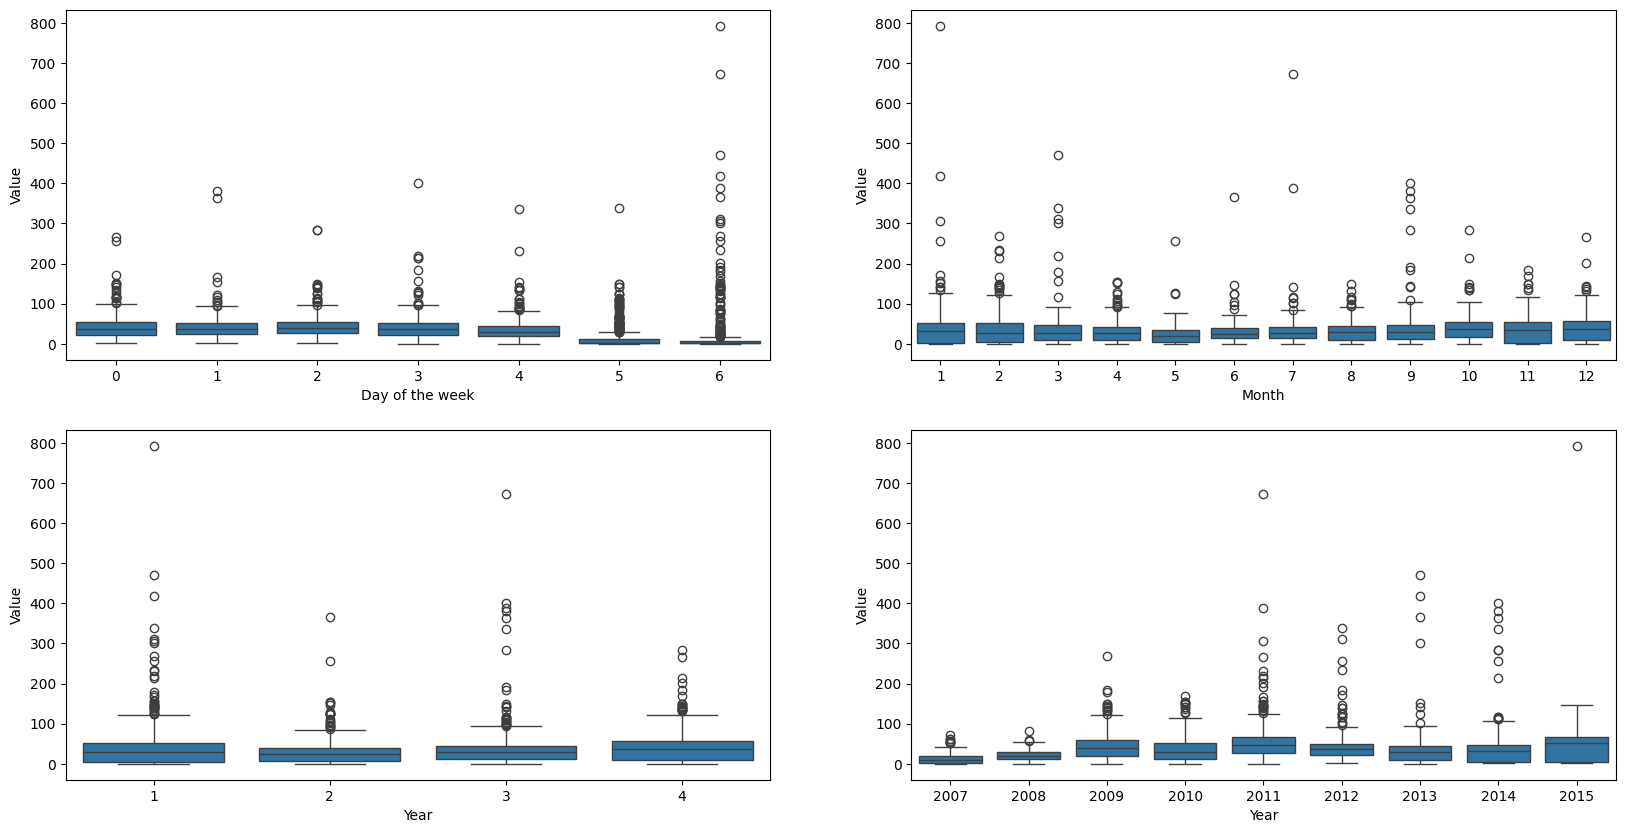

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.boxplot(x= data['Num_DayofWeek'], y = data['Value'],data = data, ax=ax[0][0]) #giorno della settimana
ax[0][0].set_xlabel('Day of the week')
ax[0][0].set_ylabel('Value')


sns.boxplot(x= data['Month'], y = data['Value'],data = data, ax=ax[0][1]) #Mese dell'anno
ax[1][0].set_xlabel('Month')
ax[1][0].set_ylabel('Value')

sns.boxplot(x= data['Quarter'], y = data['Value'],data = data, ax=ax[1][0]) #Mese dell'anno
ax[1][0].set_xlabel('Quarter')
ax[1][0].set_ylabel('Value')

sns.boxplot(x= data['Year'], y = data['Value'],data = data, ax=ax[1][1]) #Mese dell'anno
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('Value')


plt.show()

<Axes: xlabel='Month_Name', ylabel='Value'>

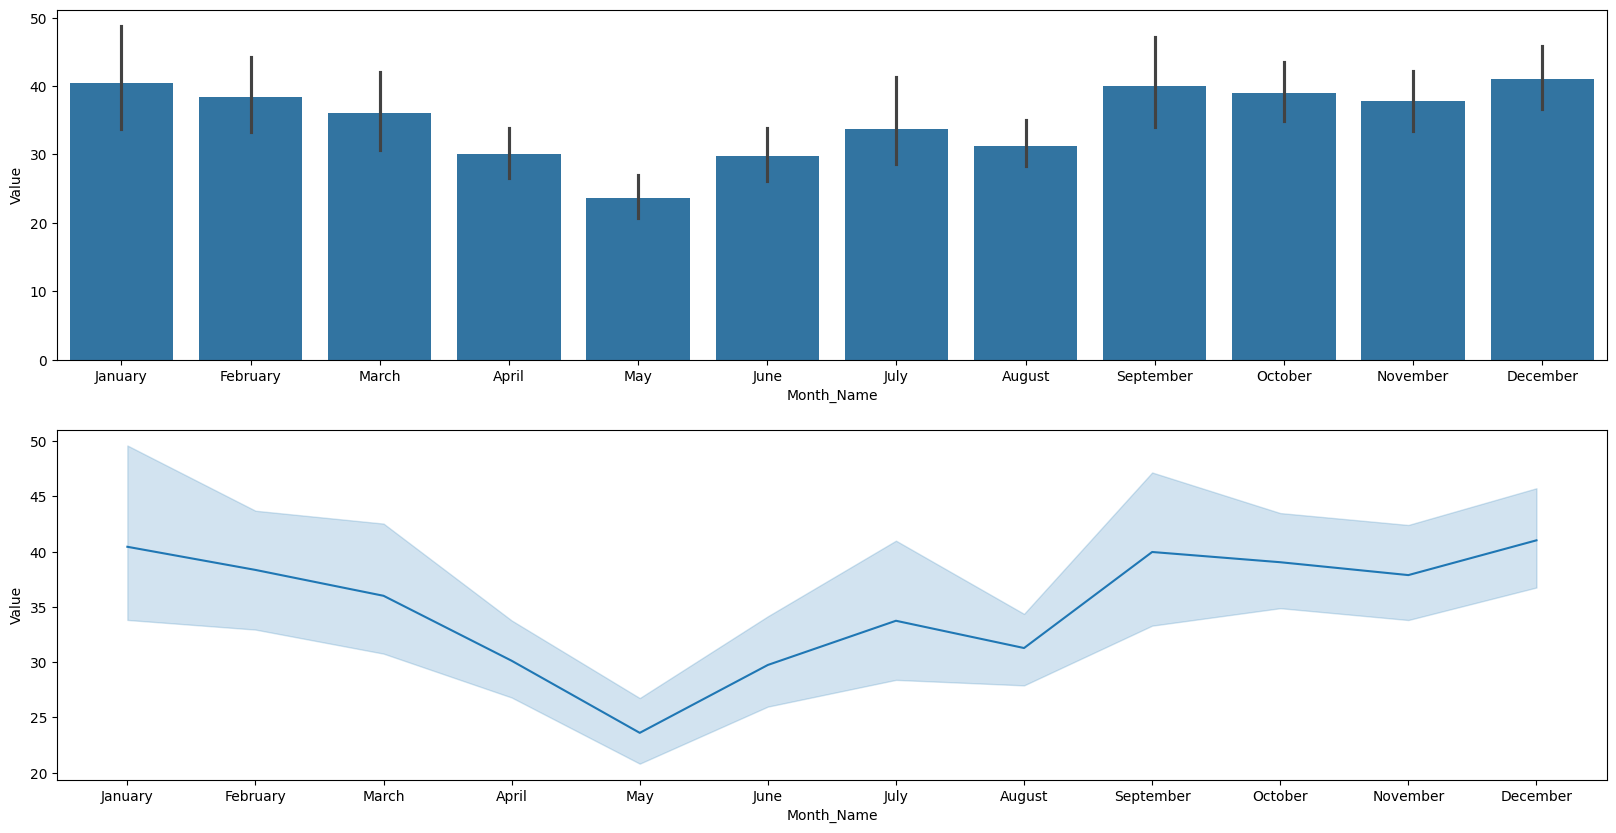

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols = 1, figsize = (20, 10))
sns.barplot(x = data['Month_Name'], y = data['Value'], ax = ax[0])
sns.lineplot(x = data['Month_Name'],y =  data['Value'], ax = ax[1])

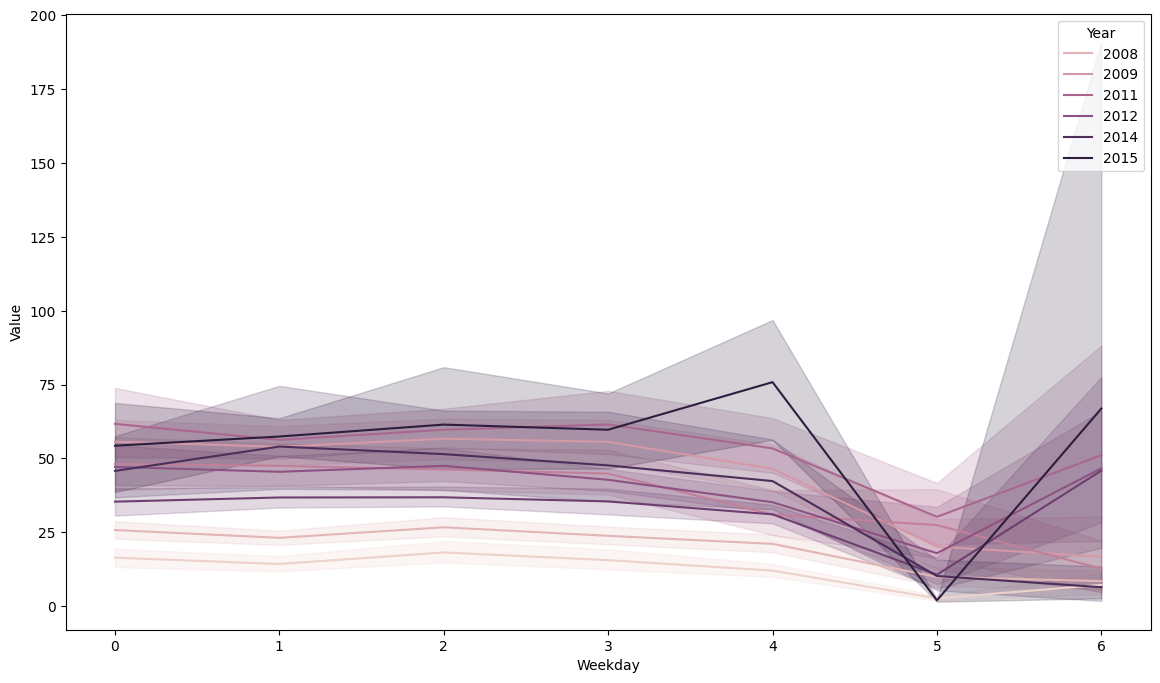

In [ ]:
plt.figure(figsize=(14, 8))
sns.lineplot(x = data['Num_DayofWeek'], y =  data['Value'], hue = data['Year'])
plt.xlabel('Weekday')
plt.ylabel('Value')
plt.show()

In [ ]:
data['Value_Log'] = np.log(data['Value'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
data[data['Value_Log'].isnull()].groupby('weekday').size()

Series([], dtype: int64)

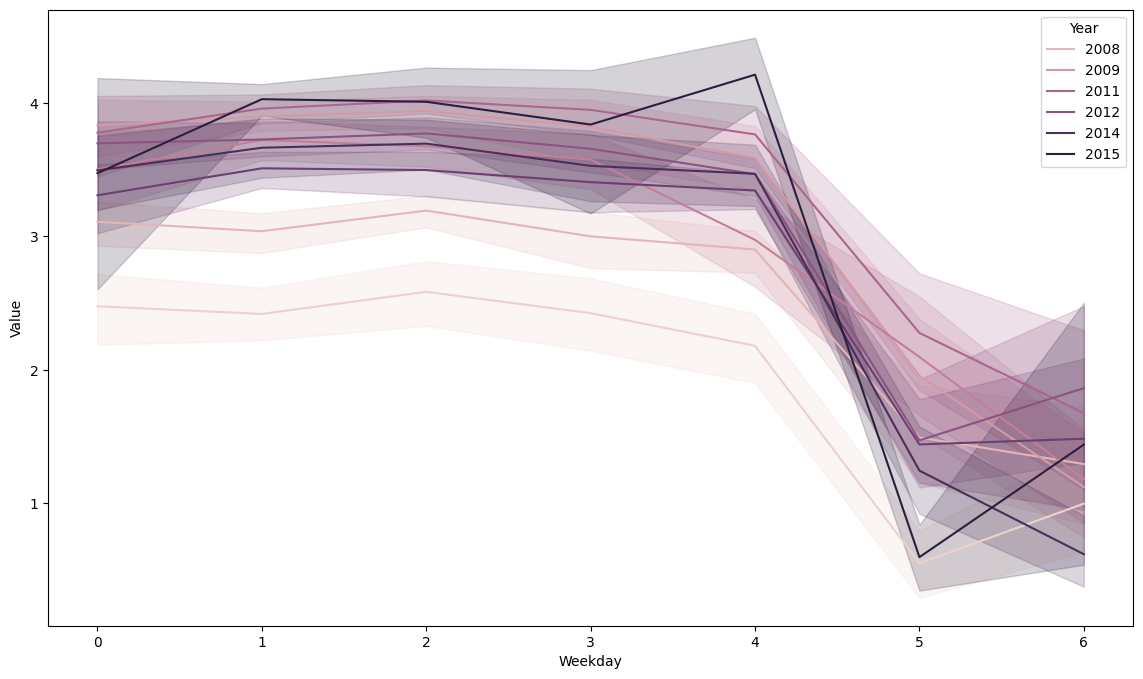

In [ ]:
plt.figure(figsize=(14, 8))
sns.lineplot(x = data['Num_DayofWeek'], y =  data['Value_Log'], hue = data['Year'])
plt.xlabel('Weekday')
plt.ylabel('Value')
plt.show()

## Outilier

In [ ]:
import pandas as pd
import numpy as np


# Calculate quartiles
q1 = data['Value'].quantile(0.25)
q2 = data['Value'].quantile(0.50)  # Median
q3 = data['Value'].quantile(0.75)

# Calculate IQR (Interquartile Range)
iqr = q3 - q1

# Define the lower and upper bounds to identify outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers = data[(data['Value'] < lower_bound) | (data['Value'] > upper_bound)]

# Print or visualize the outliers
print("Outliers:")
print(outliers)

Outliers:
              weekday       Value  Year  Month  Day Month_Name  Num_DayofYear  \
date                                                                            
2009-01-12     Monday  113.919129  2009      1   12    January             12   
2009-02-08     Sunday  268.333333  2009      2    8   February             39   
2009-03-08     Sunday  178.926829  2009      3    8      March             67   
2009-06-06   Saturday  124.248408  2009      6    6       June            157   
2009-07-11   Saturday  113.111111  2009      7   11       July            192   
...               ...         ...   ...    ...  ...        ...            ...   
2015-01-02     Friday  134.426667  2015      1    2    January              2   
2015-01-04     Sunday  792.818182  2015      1    4    January              4   
2015-01-30     Friday  142.240385  2015      1   30    January             30   
2015-02-04  Wednesday  146.310433  2015      2    4   February             35   
2015-02-06     Fri

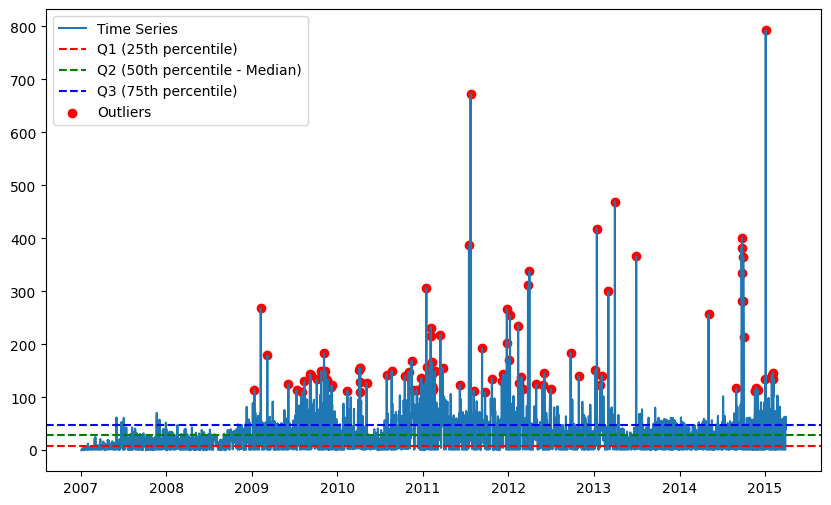

In [ ]:
# Plot the time series with quartiles and outliers
plt.figure(figsize=(10, 6))

# Line plot of the time series
plt.plot(data.index, data['Value'], label='Time Series')

# Quartiles as horizontal lines
plt.axhline(y=q1, color='r', linestyle='--', label='Q1 (25th percentile)')
plt.axhline(y=q2, color='g', linestyle='--', label='Q2 (50th percentile - Median)')
plt.axhline(y=q3, color='b', linestyle='--', label='Q3 (75th percentile)')

# Outliers as red points
plt.scatter(outliers.index, outliers['Value'], color='red', label='Outliers')

# Plot legend
plt.legend()

# Show the plot
plt.show()

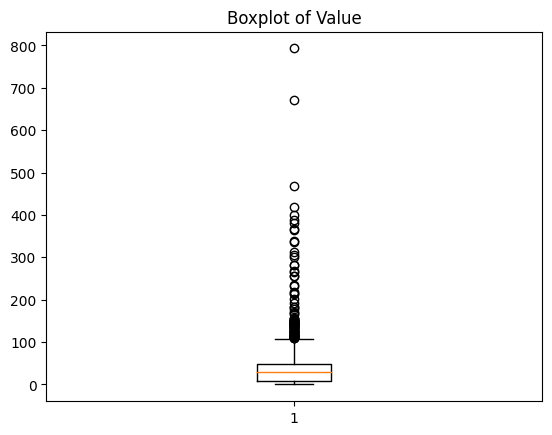

In [ ]:
plt.boxplot(data['Value'].dropna())
plt.title('Boxplot of Value')
plt.show()

In [ ]:
q3

47.4545454545455

In [ ]:
# Calculate the percentage of records that are outliers
percentage_outliers = (len(outliers) / len(data)) * 100

# Print the percentage
print(f"Percentage of records that are outliers: {percentage_outliers:.2f}%")

Percentage of records that are outliers: 3.39%


In [ ]:
import pandas as pd
from scipy.stats import mstats

# Assuming your DataFrame is named 'data'
# Winsorize the 'Value' column at the 1st and 99th percentiles
lower_limit = 0.0
upper_limit = 0.05

data['Winsorized_Value'] = mstats.winsorize(data['Value'], limits=[lower_limit, upper_limit])

# Now, 'Winsorized_Value' column contains the winsorized values
# You can use this new column for further analysis

# Print the DataFrame to check the results
print(data)


             weekday      Value  Year  Month  Day Month_Name  Num_DayofYear  \
date                                                                          
2007-01-04  Thursday   0.179487  2007      1    4    January              4   
2007-01-05    Friday   0.500000  2007      1    5    January              5   
2007-01-06  Saturday   1.000000  2007      1    6    January              6   
2007-01-07    Sunday   1.000000  2007      1    7    January              7   
2007-01-08    Monday   3.521739  2007      1    8    January              8   
...              ...        ...   ...    ...  ...        ...            ...   
2015-03-27    Friday  38.580756  2015      3   27      March             86   
2015-03-28  Saturday   1.040000  2015      3   28      March             87   
2015-03-29    Sunday  42.000000  2015      3   29      March             88   
2015-03-30    Monday  63.477124  2015      3   30      March             89   
2015-03-31   Tuesday  40.496689  2015      3   31   

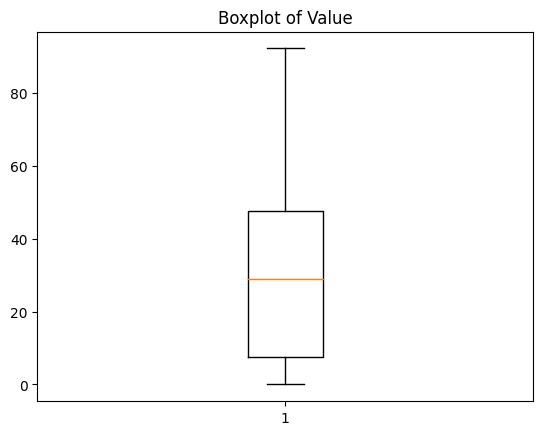

In [ ]:
plt.boxplot(data['Winsorized_Value'].dropna())
plt.title('Boxplot of Value')
plt.show()

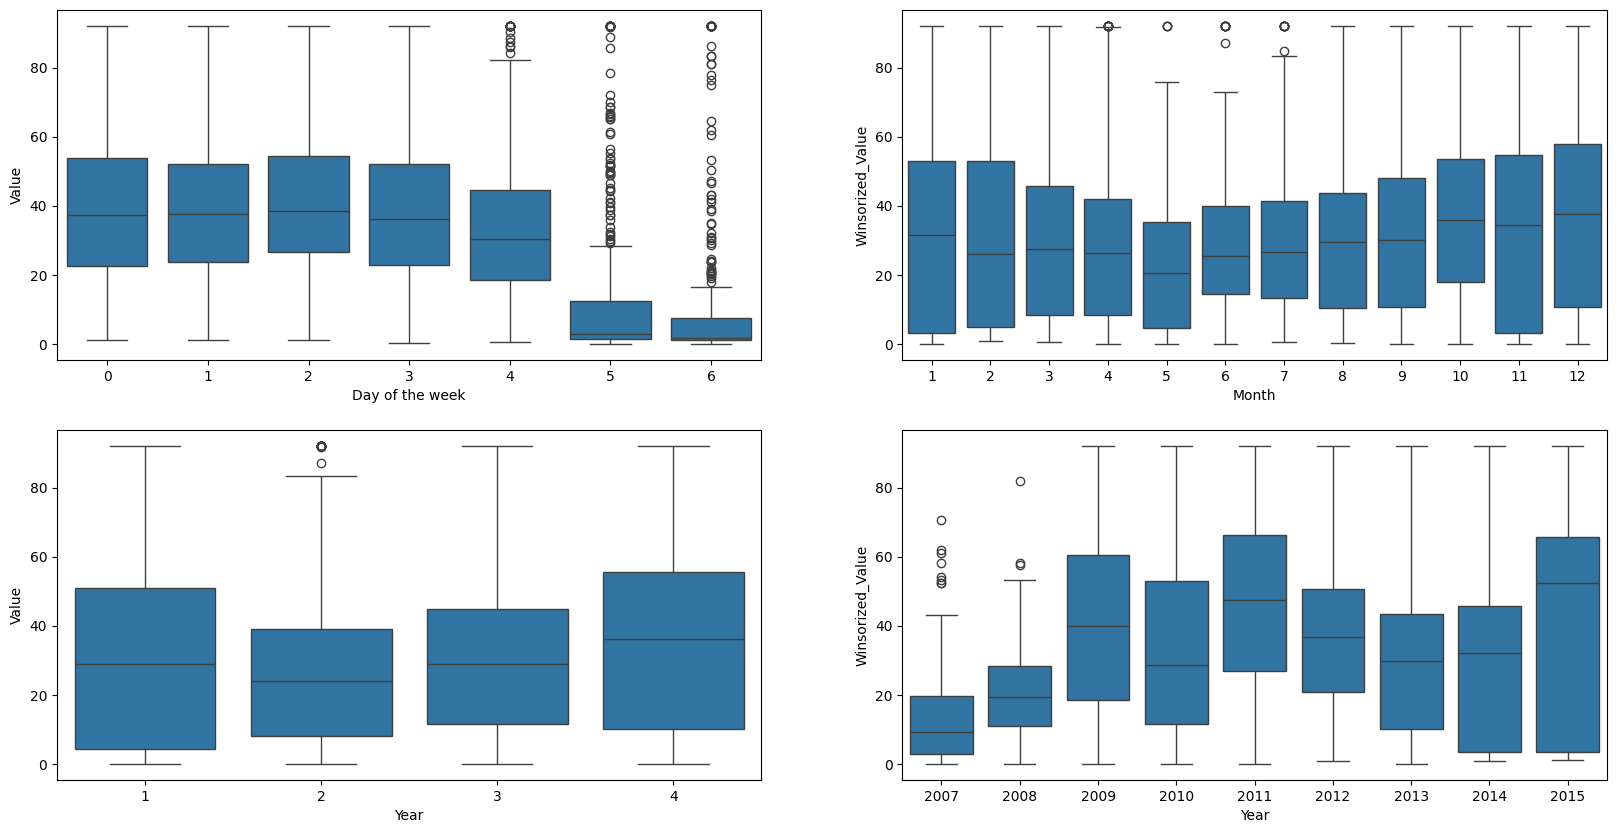

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.boxplot(x= data['Num_DayofWeek'], y = data['Winsorized_Value'],data = data, ax=ax[0][0]) #giorno della settimana
ax[0][0].set_xlabel('Day of the week')
ax[0][0].set_ylabel('Value')


sns.boxplot(x= data['Month'], y = data['Winsorized_Value'],data = data, ax=ax[0][1]) #Mese dell'anno
ax[1][0].set_xlabel('Month')
ax[1][0].set_ylabel('Value')

sns.boxplot(x= data['Quarter'], y = data['Winsorized_Value'],data = data, ax=ax[1][0]) #Mese dell'anno
ax[1][0].set_xlabel('Quarter')
ax[1][0].set_ylabel('Value')

sns.boxplot(x= data['Year'], y = data['Winsorized_Value'],data = data, ax=ax[1][1]) #Mese dell'anno
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('Value')


plt.show()

In [ ]:
data['Value'] = data['Winsorized_Value']

# ADF e KPSS

In [ ]:
# ADF Test
def run_adf_test(x):
    result_ADF = adfuller(x.values, autolag='AIC')
    print(f'ADF Statistic: {result_ADF[0]}')
    print(f'p-value: {result_ADF[1]}')
    for key, value in result_ADF[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_ADF[1] < 0.05:
        print("The time series is stationary in mean.")
    else:
        print("The time series is not stationary in mean.")

In [ ]:
# KPSS Test
def run_kpss_test(x):
    result_KPSS = kpss(x.values, regression='c')
    print('\nKPSS Statistic: %f' % result_KPSS[0])
    print('p-value: %f' % result_KPSS[1])
    for key, value in result_KPSS[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_KPSS[1] < 0.05:
        print("The time series is not stationary in variance.")
    else:
        print("The time series is stationary in variance.")

## Calcolo valori dei test sulla serie storica

In [ ]:
resultADF = run_adf_test(data['Value'])

ADF Statistic: -3.6987300192197092
p-value: 0.004131053058150289
Critical Values:
   1%, -3.432545551806462
Critical Values:
   5%, -2.8625100519404665
Critical Values:
   10%, -2.5672863845358074
The time series is stationary in mean.


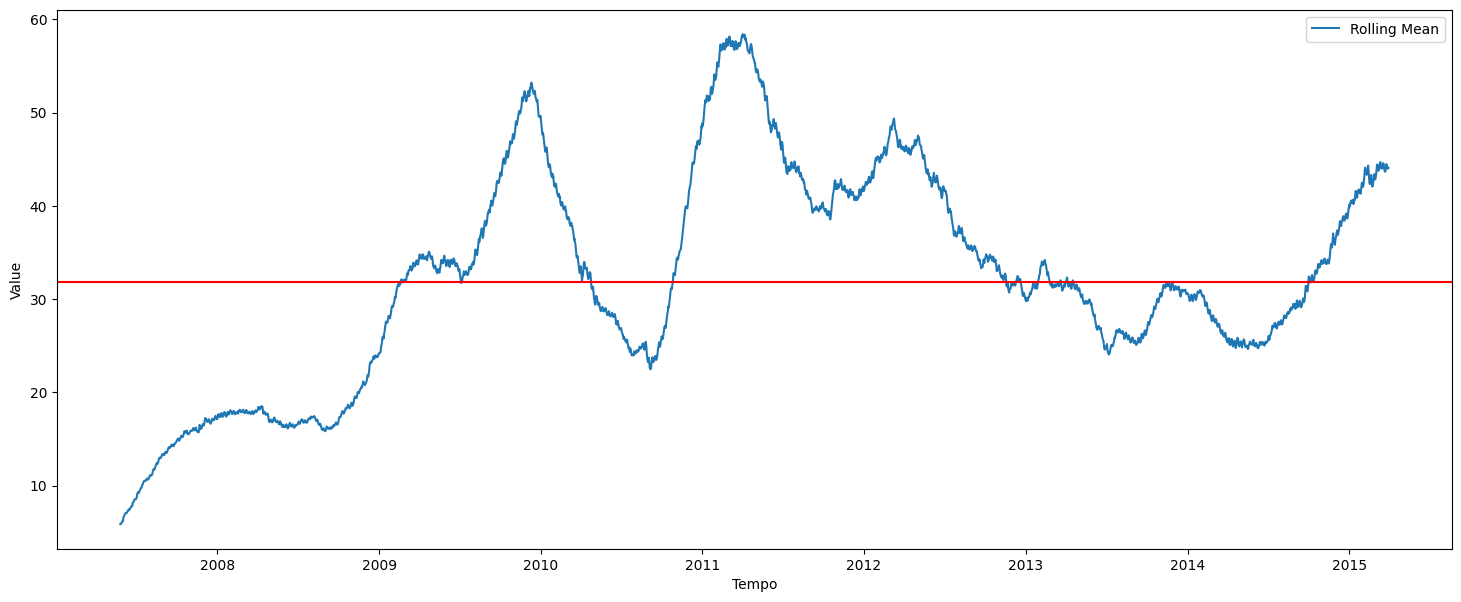

In [ ]:
# Calcolo la media rolling giornaliera della serie storica
rolling_mean = data['Value'].rolling(window=144).mean() #144 è 24*6 quindi un giorno
                                                        #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_mean, label="Rolling Mean")
plt.axhline(data['Value'].mean(), color="red")
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

### KPSS

In [ ]:
resultKPSS = run_kpss_test(data['Value'])


KPSS Statistic: 2.952166
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


<ipython-input-42-0f245ae750f4>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_KPSS = kpss(x.values, regression='c')


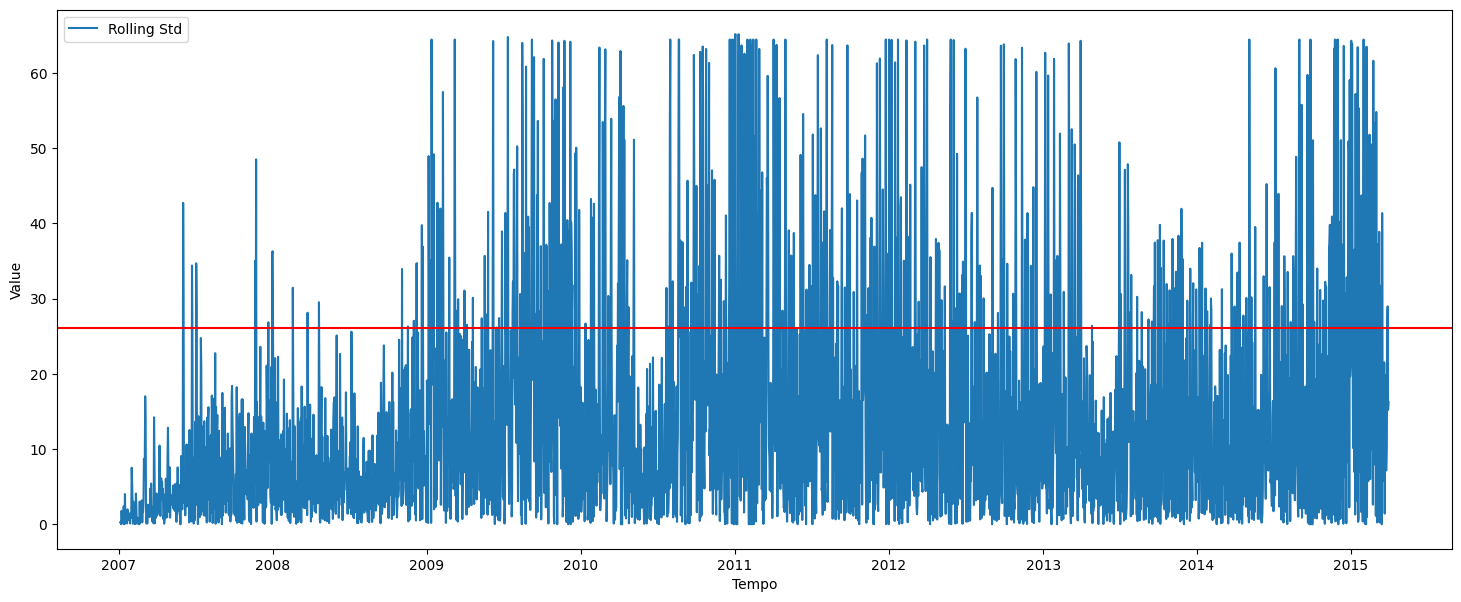

In [ ]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value'].rolling(window=2).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std")
plt.axhline(data['Value'].std(), color="red")
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

## Trasformazioni

### Log

In [ ]:
# data.loc[data['Value'] < 1, 'Value'] = 1

In [ ]:
data['Value_Log'] = np.log1p(data["Value"] + 1)
print(data['Value_Log'])

date
2007-01-04    0.779090
2007-01-05    0.916291
2007-01-06    1.098612
2007-01-07    1.098612
2007-01-08    1.708693
                ...   
2015-03-27    3.703294
2015-03-28    1.111858
2015-03-29    3.784190
2015-03-30    4.181701
2015-03-31    3.749426
Name: Value_Log, Length: 3009, dtype: float64


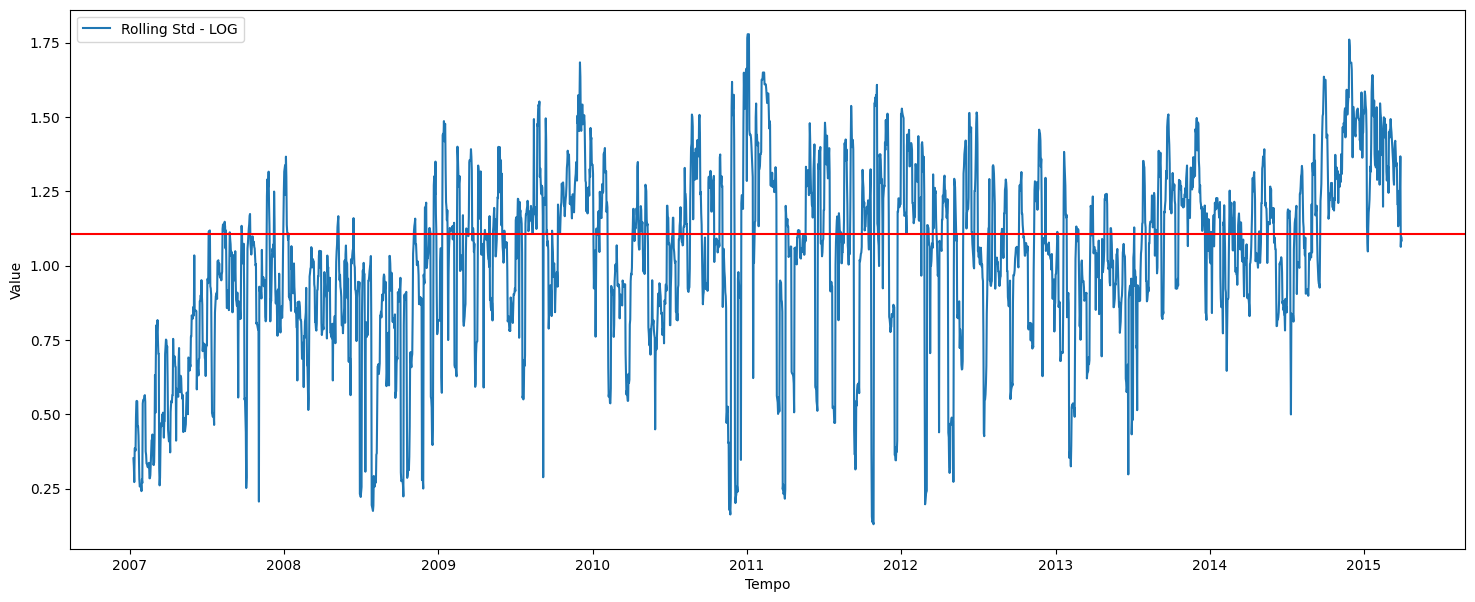

In [ ]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value_Log'].rolling(window=7).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std - LOG")
plt.axhline(data['Value_Log'].std(), color="red")
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
run_adf_test(data['Value_Log'])

ADF Statistic: -4.457063522740238
p-value: 0.0002349168849814916
Critical Values:
   1%, -3.4325462892049194
Critical Values:
   5%, -2.8625103776222067
Critical Values:
   10%, -2.5672865579253186
The time series is stationary in mean.


In [ ]:
run_kpss_test(data['Value_Log'])


KPSS Statistic: 5.067869
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


<ipython-input-42-0f245ae750f4>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_KPSS = kpss(x.values, regression='c')


### Box-Cox

In [ ]:
# # Cerco il lambda ottimale
# lambda_opt = boxcox_normmax(data['Value'])
# print(lambda_opt)

# # Applico Box-Cox con il lambda ottimale trovato
# data['Value_BoxCox'] = boxcox(data['Value'], lmbda=lambda_opt)
# print(data['Value_BoxCox'])

In [ ]:
# run_adf_test(data['Value_BoxCox'])

In [ ]:
# run_kpss_test(data['Value_BoxCox'])

### Differenziazione

In [ ]:
data

weekday      Value  Year  Month  Day Month_Name  Num_DayofYear  \
date                                                                          
2007-01-04  Thursday   0.179487  2007      1    4    January              4   
2007-01-05    Friday   0.500000  2007      1    5    January              5   
2007-01-06  Saturday   1.000000  2007      1    6    January              6   
2007-01-07    Sunday   1.000000  2007      1    7    January              7   
2007-01-08    Monday   3.521739  2007      1    8    January              8   
...              ...        ...   ...    ...  ...        ...            ...   
2015-03-27    Friday  38.580756  2015      3   27      March             86   
2015-03-28  Saturday   1.040000  2015      3   28      March             87   
2015-03-29    Sunday  42.000000  2015      3   29      March             88   
2015-03-30    Monday  63.477124  2015      3   30      March             89   
2015-03-31   Tuesday  40.496689  2015      3   31      March             90   

            Num_DayofWeek  Num_WeekofYear  Quarter   Just_Date  Is_Sunday  \
date                                                                        
2007-01-04              3               1        1  2007-01-04          0   
2007-01-05              4               1        1  2007-01-05          0   
2007-01-06              5               1        1  2007-01-06          0   
2007-01-07              6               1        1  2007-01-07          1   
2007-01-08              0               2        1  2007-01-08          0   
...                   ...             ...      ...         ...        ...   
2015-03-27              4              13        1  2015-03-27          0   
2015-03-28              5              13        1  2015-03-28          0   
2015-03-29              6              13        1  2015-03-29          1   
2015-03-30              0              14        1  2015-03-30          0   
2015-03-31              1              14        1  2015-03-31          0   

            Is_Christmas  Is_Easter  Is_Last_of_Year  Is_Aug_15  Value_Log  \
date                                                                         
2007-01-04             0          0                0          0   0.779090   
2007-01-05             0          0                0          0   0.916291   
2007-01-06             0          0                0          0   1.098612   
2007-01-07             0          0                0          0   1.098612   
2007-01-08             0          0                0          0   1.708693   
...                  ...        ...              ...        ...        ...   
2015-03-27             0          0                0          0   3.703294   
2015-03-28             0          0                0          0   1.111858   
2015-03-29             0          1                0          0   3.784190   
2015-03-30             0          0                0          0   4.181701   
2015-03-31             0          0                0          0   3.749426   

            Winsorized_Value  
date                          
2007-01-04          0.179487  
2007-01-05          0.500000  
2007-01-06          1.000000  
2007-01-07          1.000000  
2007-01-08          3.521739  
...                      ...  
2015-03-27         38.580756  
2015-03-28          1.040000  
2015-03-29         42.000000  
2015-03-30         63.477124  
2015-03-31         40.496689  

[3009 rows x 18 columns]

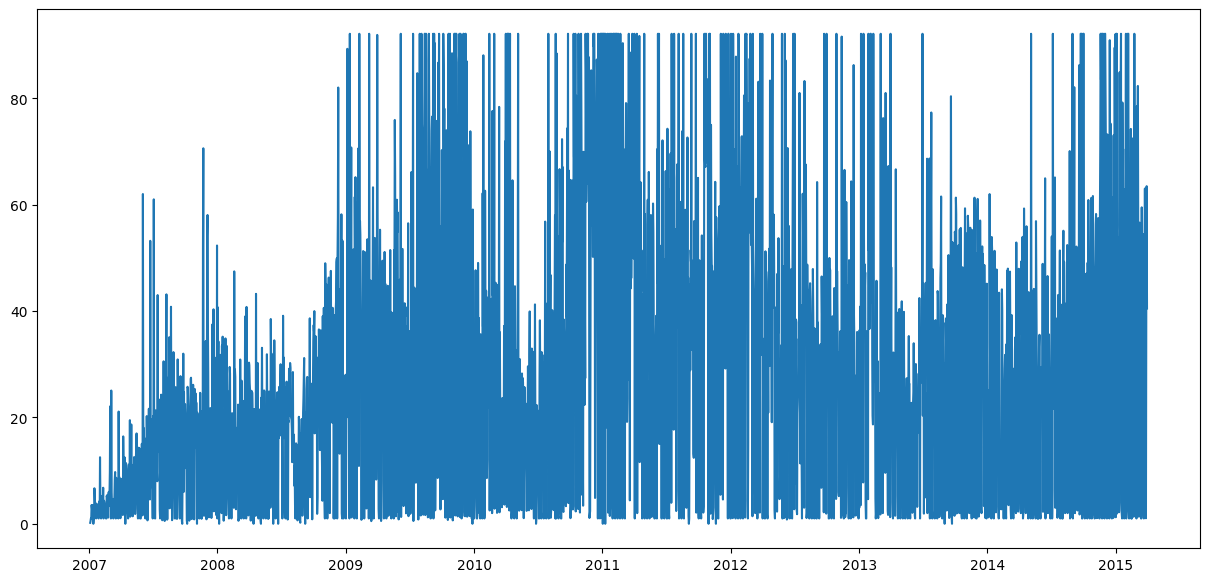

In [ ]:
fig, ax = plt.subplots(1, 1, figsize =(15,7))
plt.plot(data['Value'])

In [ ]:
data_diff = data.copy()

In [ ]:
data_diff['Value'] = data_diff['Value'].diff(7)
print(data_diff['Value'])

date
2007-01-04          NaN
2007-01-05          NaN
2007-01-06          NaN
2007-01-07          NaN
2007-01-08          NaN
                ...    
2015-03-27     5.157027
2015-03-28    -1.960000
2015-03-29    41.000000
2015-03-30    34.408033
2015-03-31   -12.236645
Name: Value, Length: 3009, dtype: float64


In [ ]:

data_diff = data_diff.dropna()
print(data_diff['Value'])

date
2007-01-11     3.320513
2007-01-12     2.866197
2007-01-13    -1.000000
2007-01-14     0.000000
2007-01-15    -2.521739
                ...    
2015-03-27     5.157027
2015-03-28    -1.960000
2015-03-29    41.000000
2015-03-30    34.408033
2015-03-31   -12.236645
Name: Value, Length: 3002, dtype: float64


In [ ]:
run_adf_test(data_diff['Value'])

ADF Statistic: -16.66603643767965
p-value: 1.5593858378900095e-29
Critical Values:
   1%, -3.4325507240185105
Critical Values:
   5%, -2.862512336314338
Critical Values:
   10%, -2.5672876007125645
The time series is stationary in mean.


In [ ]:
run_kpss_test(data_diff['Value'])


KPSS Statistic: 0.009829
p-value: 0.100000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is stationary in variance.


<ipython-input-42-0f245ae750f4>:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result_KPSS = kpss(x.values, regression='c')


## ACF e PACF

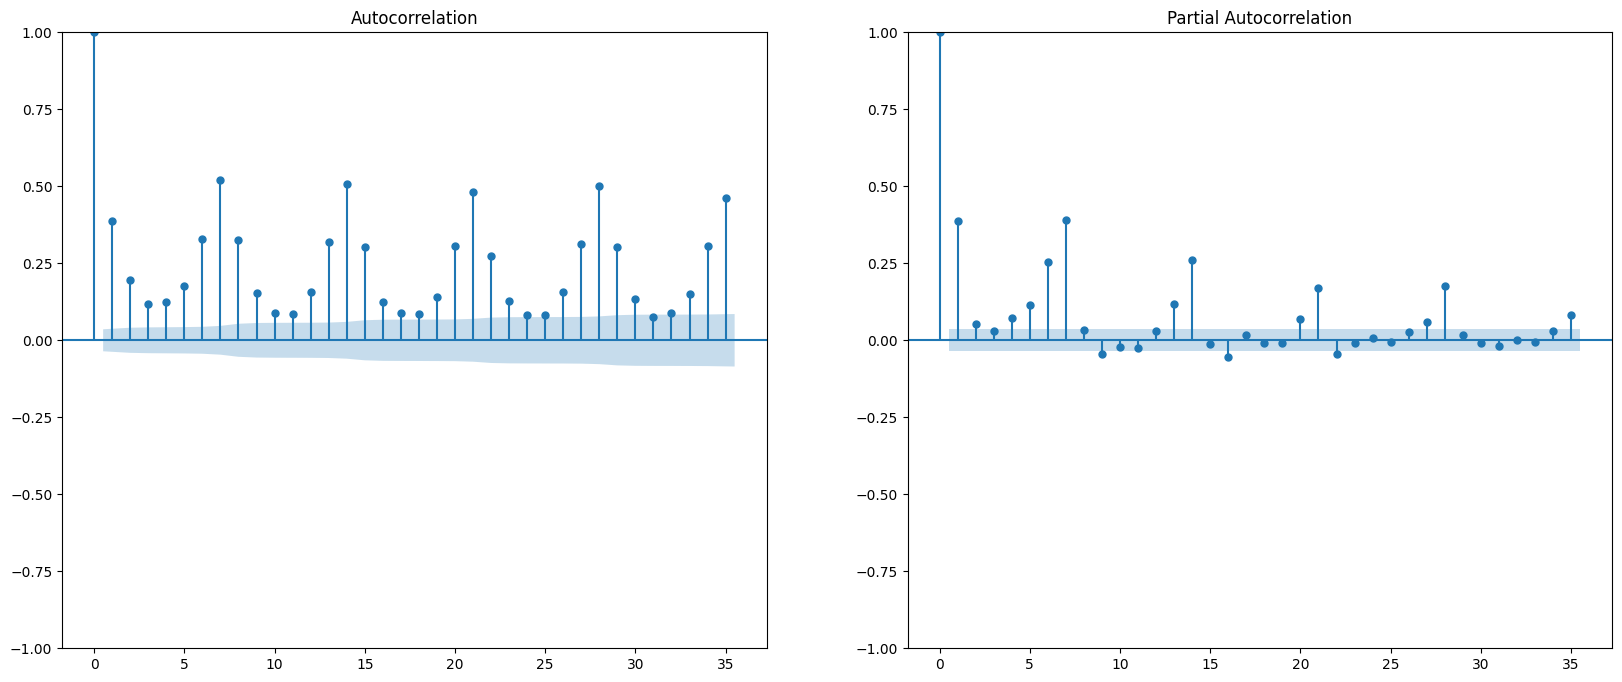

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data['Value'], ax = ax[0])
plot_pacf(data['Value'], ax = ax[1])

plt.show()

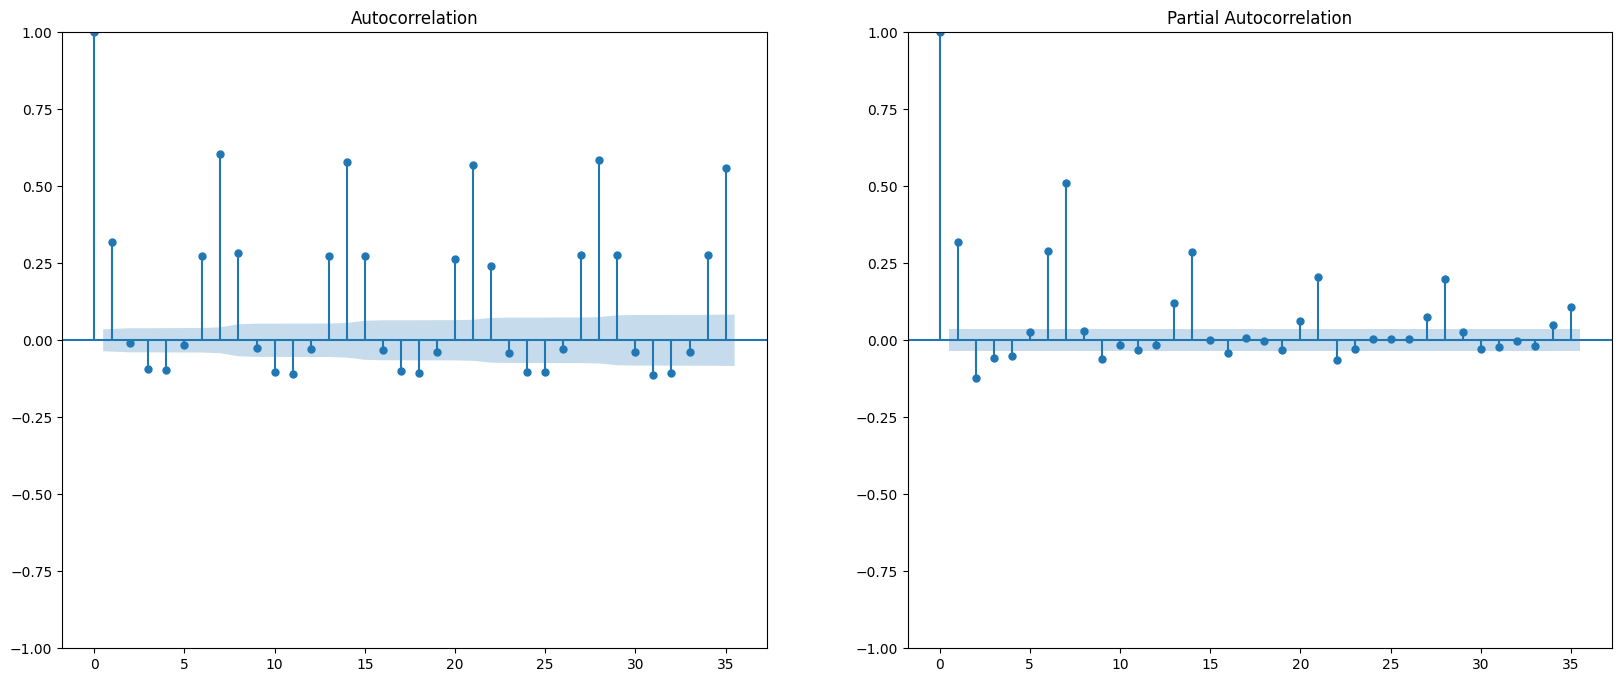

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data['Value_Log'], ax = ax[0])
plot_pacf(data['Value_Log'], ax = ax[1])

plt.show()

# Machine Learning

## Train - Validation split

In [ ]:
data

weekday      Value  Year  Month  Day Month_Name  Num_DayofYear  \
date                                                                          
2007-01-04  Thursday   0.179487  2007      1    4    January              4   
2007-01-05    Friday   0.500000  2007      1    5    January              5   
2007-01-06  Saturday   1.000000  2007      1    6    January              6   
2007-01-07    Sunday   1.000000  2007      1    7    January              7   
2007-01-08    Monday   3.521739  2007      1    8    January              8   
...              ...        ...   ...    ...  ...        ...            ...   
2015-03-27    Friday  38.580756  2015      3   27      March             86   
2015-03-28  Saturday   1.040000  2015      3   28      March             87   
2015-03-29    Sunday  42.000000  2015      3   29      March             88   
2015-03-30    Monday  63.477124  2015      3   30      March             89   
2015-03-31   Tuesday  40.496689  2015      3   31      March             90   

            Num_DayofWeek  Num_WeekofYear  Quarter   Just_Date  Is_Sunday  \
date                                                                        
2007-01-04              3               1        1  2007-01-04          0   
2007-01-05              4               1        1  2007-01-05          0   
2007-01-06              5               1        1  2007-01-06          0   
2007-01-07              6               1        1  2007-01-07          1   
2007-01-08              0               2        1  2007-01-08          0   
...                   ...             ...      ...         ...        ...   
2015-03-27              4              13        1  2015-03-27          0   
2015-03-28              5              13        1  2015-03-28          0   
2015-03-29              6              13        1  2015-03-29          1   
2015-03-30              0              14        1  2015-03-30          0   
2015-03-31              1              14        1  2015-03-31          0   

            Is_Christmas  Is_Easter  Is_Last_of_Year  Is_Aug_15  Value_Log  \
date                                                                         
2007-01-04             0          0                0          0   0.779090   
2007-01-05             0          0                0          0   0.916291   
2007-01-06             0          0                0          0   1.098612   
2007-01-07             0          0                0          0   1.098612   
2007-01-08             0          0                0          0   1.708693   
...                  ...        ...              ...        ...        ...   
2015-03-27             0          0                0          0   3.703294   
2015-03-28             0          0                0          0   1.111858   
2015-03-29             0          1                0          0   3.784190   
2015-03-30             0          0                0          0   4.181701   
2015-03-31             0          0                0          0   3.749426   

            Winsorized_Value  
date                          
2007-01-04          0.179487  
2007-01-05          0.500000  
2007-01-06          1.000000  
2007-01-07          1.000000  
2007-01-08          3.521739  
...                      ...  
2015-03-27         38.580756  
2015-03-28          1.040000  
2015-03-29         42.000000  
2015-03-30         63.477124  
2015-03-31         40.496689  

[3009 rows x 18 columns]

In [ ]:
train = data.loc[ "2007-01-04": "2014-08-23"]
validation = data.loc["2014-08-24" : ]

In [ ]:
#defining input and target variable
X_train = train.loc["2007-01-04": "2014-08-23", ['Num_DayofYear',
                                                'Month', "Num_DayofWeek", "Year",
                                                'Num_WeekofYear', 'Quarter', 'Is_Sunday', 'Is_Christmas',
                                                 'Is_Easter', 'Is_Last_of_Year', 'Is_Aug_15']]

y_train = train.loc["2007-01-04": "2014-08-23", ['Value_Log']]

X_test = validation.loc["2014-08-24" : '2015-03-31', ['Num_DayofYear',
                                                'Month', "Num_DayofWeek", "Year",
                                                'Num_WeekofYear', 'Quarter', 'Is_Sunday', 'Is_Christmas',
                                                 'Is_Easter', 'Is_Last_of_Year', 'Is_Aug_15']]

y_test = validation.loc["2014-08-24" : '2015-03-31', ['Value_Log']]


## XGBOOST

In [ ]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#XGBoost hyper-parameter tuning

def hyperParameterTuning(X_train, y_train):
    param_grid = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:linear']
    }

    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                               param_grid = param_grid,
                               scoring = 'neg_mean_absolute_error', #MAE
                               #scoring = 'neg_mean_squared_error',  #MSE
                               cv = 5,
                               n_jobs = -1,
                               verbose = 1)
    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

In [ ]:
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:30:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 100,
 'objective': 'reg:linear',
 'subsample': 0.5}

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error


xgb_model1 = XGBRegressor(booster='gbtree',
                          colsample_bytree = 0.7,
                          learning_rate = 0.01,
                          max_depth = 3,
                          min_child_weight = 5,
                          n_estimators = 500,
                          objective = 'reg:linear',
                          subsample = 0.5)
xgb_model1.fit(X_train,y_train)
validation['xgb_hyp_params_prediction'] = xgb_model1.predict(X_test)
validation['xgb_hyp_params_prediction']
# np.sqrt(mean_squared_error(y_test,validation_tot['xgb_hyp_params_prediction']))

mae_value = metrics.mean_absolute_error(validation['xgb_hyp_params_prediction'], y_test)
print("MAE value is:", mae_value)

MAE value is: 0.6506219886761709


In [ ]:
validation

weekday      Value  Year  Month  Day Month_Name  Num_DayofYear  \
date                                                                           
2014-08-24     Sunday   1.000000  2014      8   24     August            236   
2014-08-25     Monday  34.140000  2014      8   25     August            237   
2014-08-26    Tuesday  45.624260  2014      8   26     August            238   
2014-08-27  Wednesday  34.709790  2014      8   27     August            239   
2014-08-28   Thursday  30.601156  2014      8   28     August            240   
...               ...        ...   ...    ...  ...        ...            ...   
2015-03-27     Friday  38.580756  2015      3   27      March             86   
2015-03-28   Saturday   1.040000  2015      3   28      March             87   
2015-03-29     Sunday  42.000000  2015      3   29      March             88   
2015-03-30     Monday  63.477124  2015      3   30      March             89   
2015-03-31    Tuesday  40.496689  2015      3   31      March             90   

            Num_DayofWeek  Num_WeekofYear  Quarter   Just_Date  Is_Sunday  \
date                                                                        
2014-08-24              6              34        3  2014-08-24          1   
2014-08-25              0              35        3  2014-08-25          0   
2014-08-26              1              35        3  2014-08-26          0   
2014-08-27              2              35        3  2014-08-27          0   
2014-08-28              3              35        3  2014-08-28          0   
...                   ...             ...      ...         ...        ...   
2015-03-27              4              13        1  2015-03-27          0   
2015-03-28              5              13        1  2015-03-28          0   
2015-03-29              6              13        1  2015-03-29          1   
2015-03-30              0              14        1  2015-03-30          0   
2015-03-31              1              14        1  2015-03-31          0   

            Is_Christmas  Is_Easter  Is_Last_of_Year  Is_Aug_15  Value_Log  \
date                                                                         
2014-08-24             0          0                0          0   1.098612   
2014-08-25             0          0                0          0   3.587400   
2014-08-26             0          0                0          0   3.863342   
2014-08-27             0          0                0          0   3.603043   
2014-08-28             0          0                0          0   3.484348   
...                  ...        ...              ...        ...        ...   
2015-03-27             0          0                0          0   3.703294   
2015-03-28             0          0                0          0   1.111858   
2015-03-29             0          1                0          0   3.784190   
2015-03-30             0          0                0          0   4.181701   
2015-03-31             0          0                0          0   3.749426   

            Winsorized_Value  xgb_hyp_params_prediction  
date                                                     
2014-08-24          1.000000                   1.633902  
2014-08-25         34.140000                   3.563374  
2014-08-26         45.624260                   3.580533  
2014-08-27         34.709790                   3.579767  
2014-08-28         30.601156                   3.563039  
...                      ...                        ...  
2015-03-27         38.580756                   3.373115  
2015-03-28          1.040000                   2.138452  
2015-03-29         42.000000                   2.258288  
2015-03-30         63.477124                   3.485583  
2015-03-31         40.496689                   3.519810  

[220 rows x 19 columns]

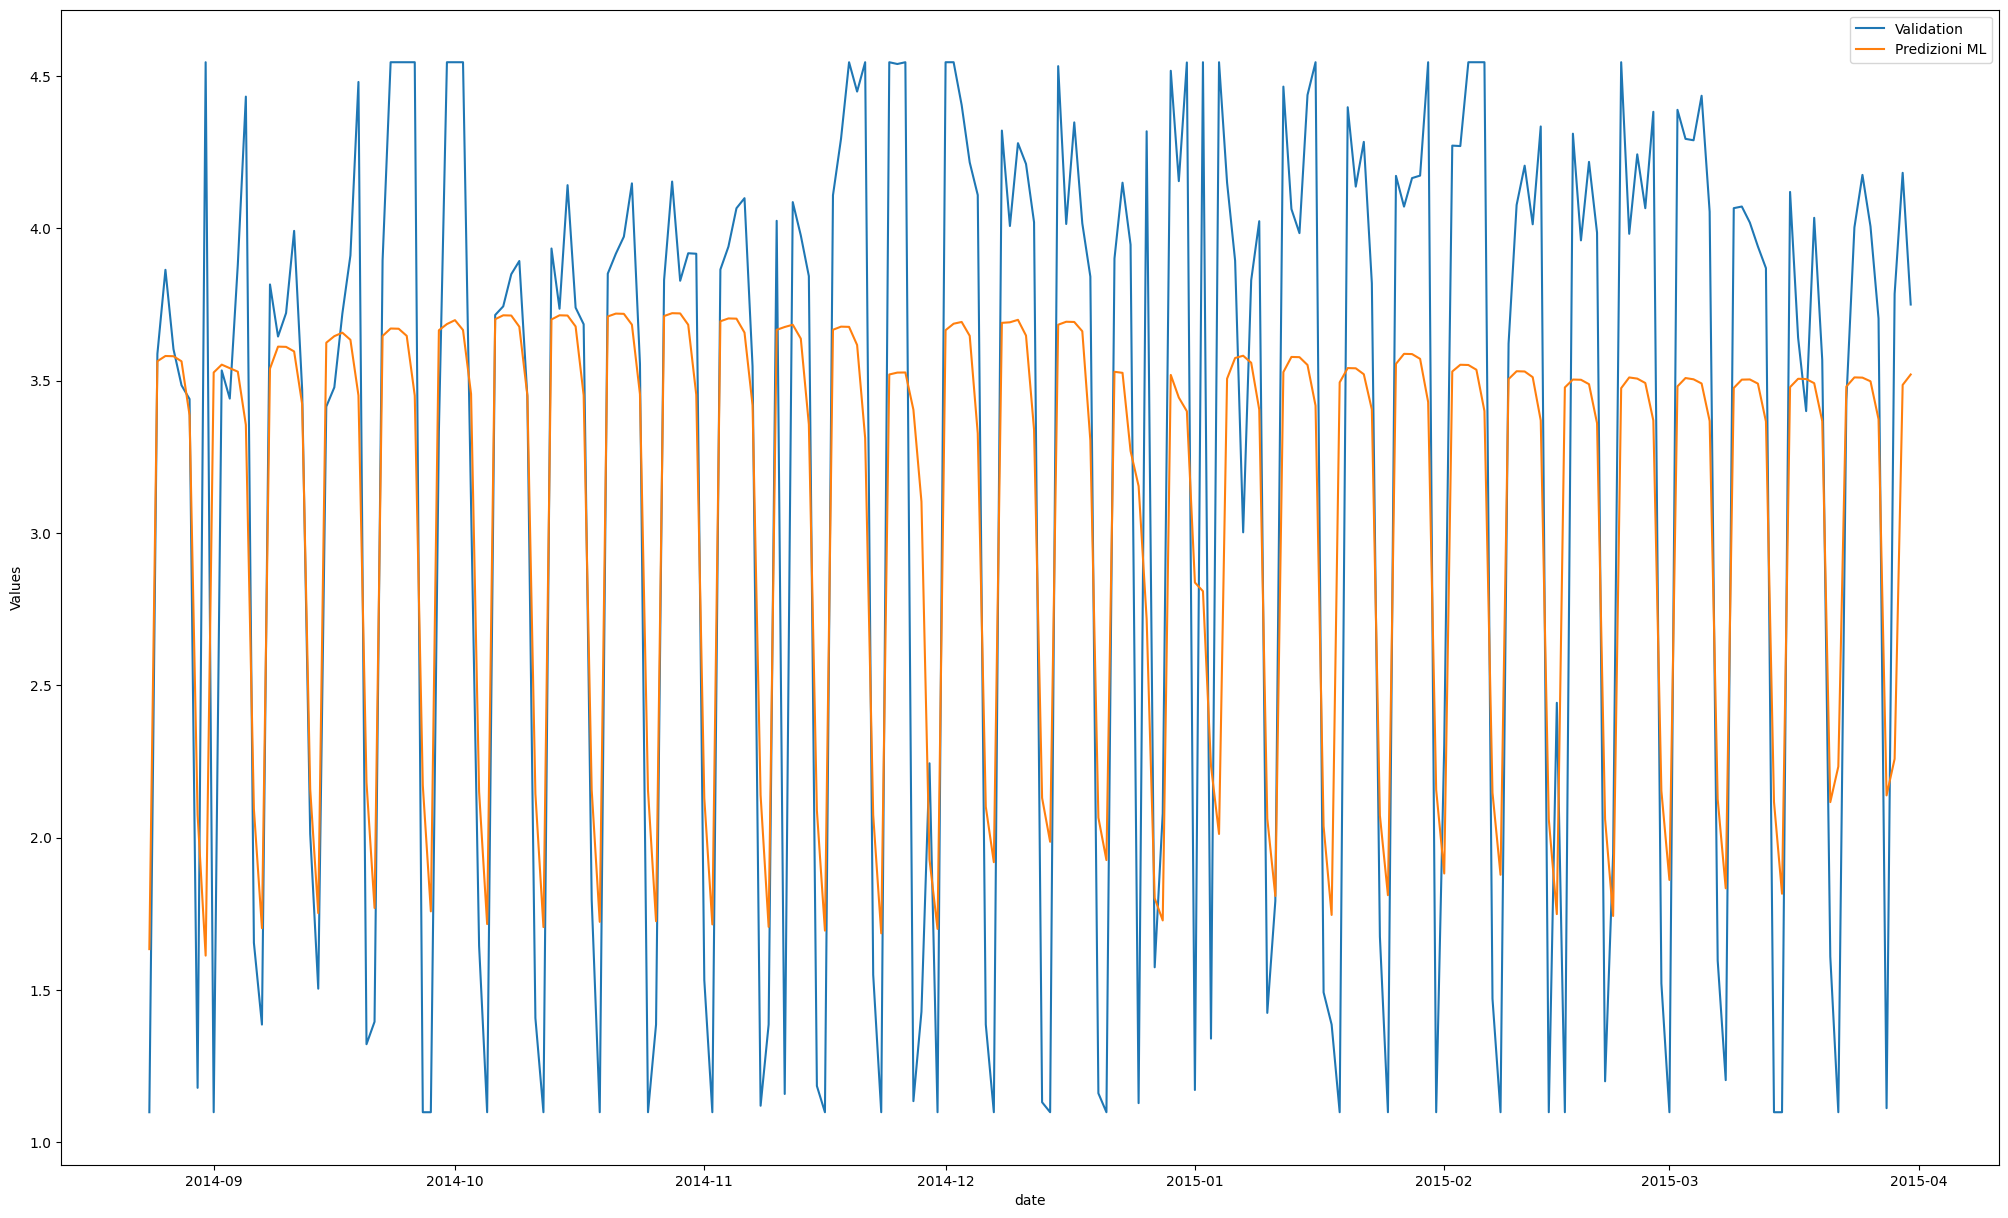

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(validation.index, validation.Value_Log, label='Validation')
plt.plot(validation.index, validation.xgb_hyp_params_prediction, label='Predizioni ML')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()


## LIGHT

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

param_grid = {'boosting_type': ['gbdt'],
'colsample_bytree': [0.5, 0.7, 0.9],
'learning_rate': [0.1],
'max_depth': [5, 6, 7],
'min_child_weight': [3, 4, 5],
'n_estimators': [100, 200, 300],
'objective': ['regression'],
'subsample': [0.5]}

lgb_model = lgb.LGBMRegressor()

grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_lgb_model = lgb.LGBMRegressor(**best_params)
best_lgb_model.fit(X_train, y_train)

Output streaming troncato alle ultime 5000 righe.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=

LGBMRegressor(colsample_bytree=0.5, max_depth=5, min_child_weight=3,
              objective='regression', subsample=0.5)

In [ ]:
best_params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 100,
 'objective': 'regression',
 'subsample': 0.5}

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

lightgbm_grid_best = lgb.LGBMRegressor(
    boosting_type='gbdt',
    colsample_bytree=0.5,
    learning_rate = 0.1,
    max_depth=6,
    min_child_weight=3,
    n_estimators=100,
    objective='regression',
    subsample=0.5,
    random_state = 123
)

# Addestramento del modello con i dati
lightgbm_grid_best.fit(X_train ,y_train)

#Predict the test data
y_pred_lightgbm = lightgbm_grid_best.predict(X_test)
# np.sqrt(mean_squared_error(y_test,validation_tot['rf_prediction_grid_best']))

mae_lightgbm = metrics.mean_absolute_error(y_pred_lightgbm, y_test)
print("MAE value is:", mae_lightgbm)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 345
[LightGBM] [Info] Number of data points in the train set: 2789, number of used features: 7
[LightGBM] [Info] Start training from score 3.058215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [ ]:
validation['y_pred_lightgbm'] = y_pred_lightgbm

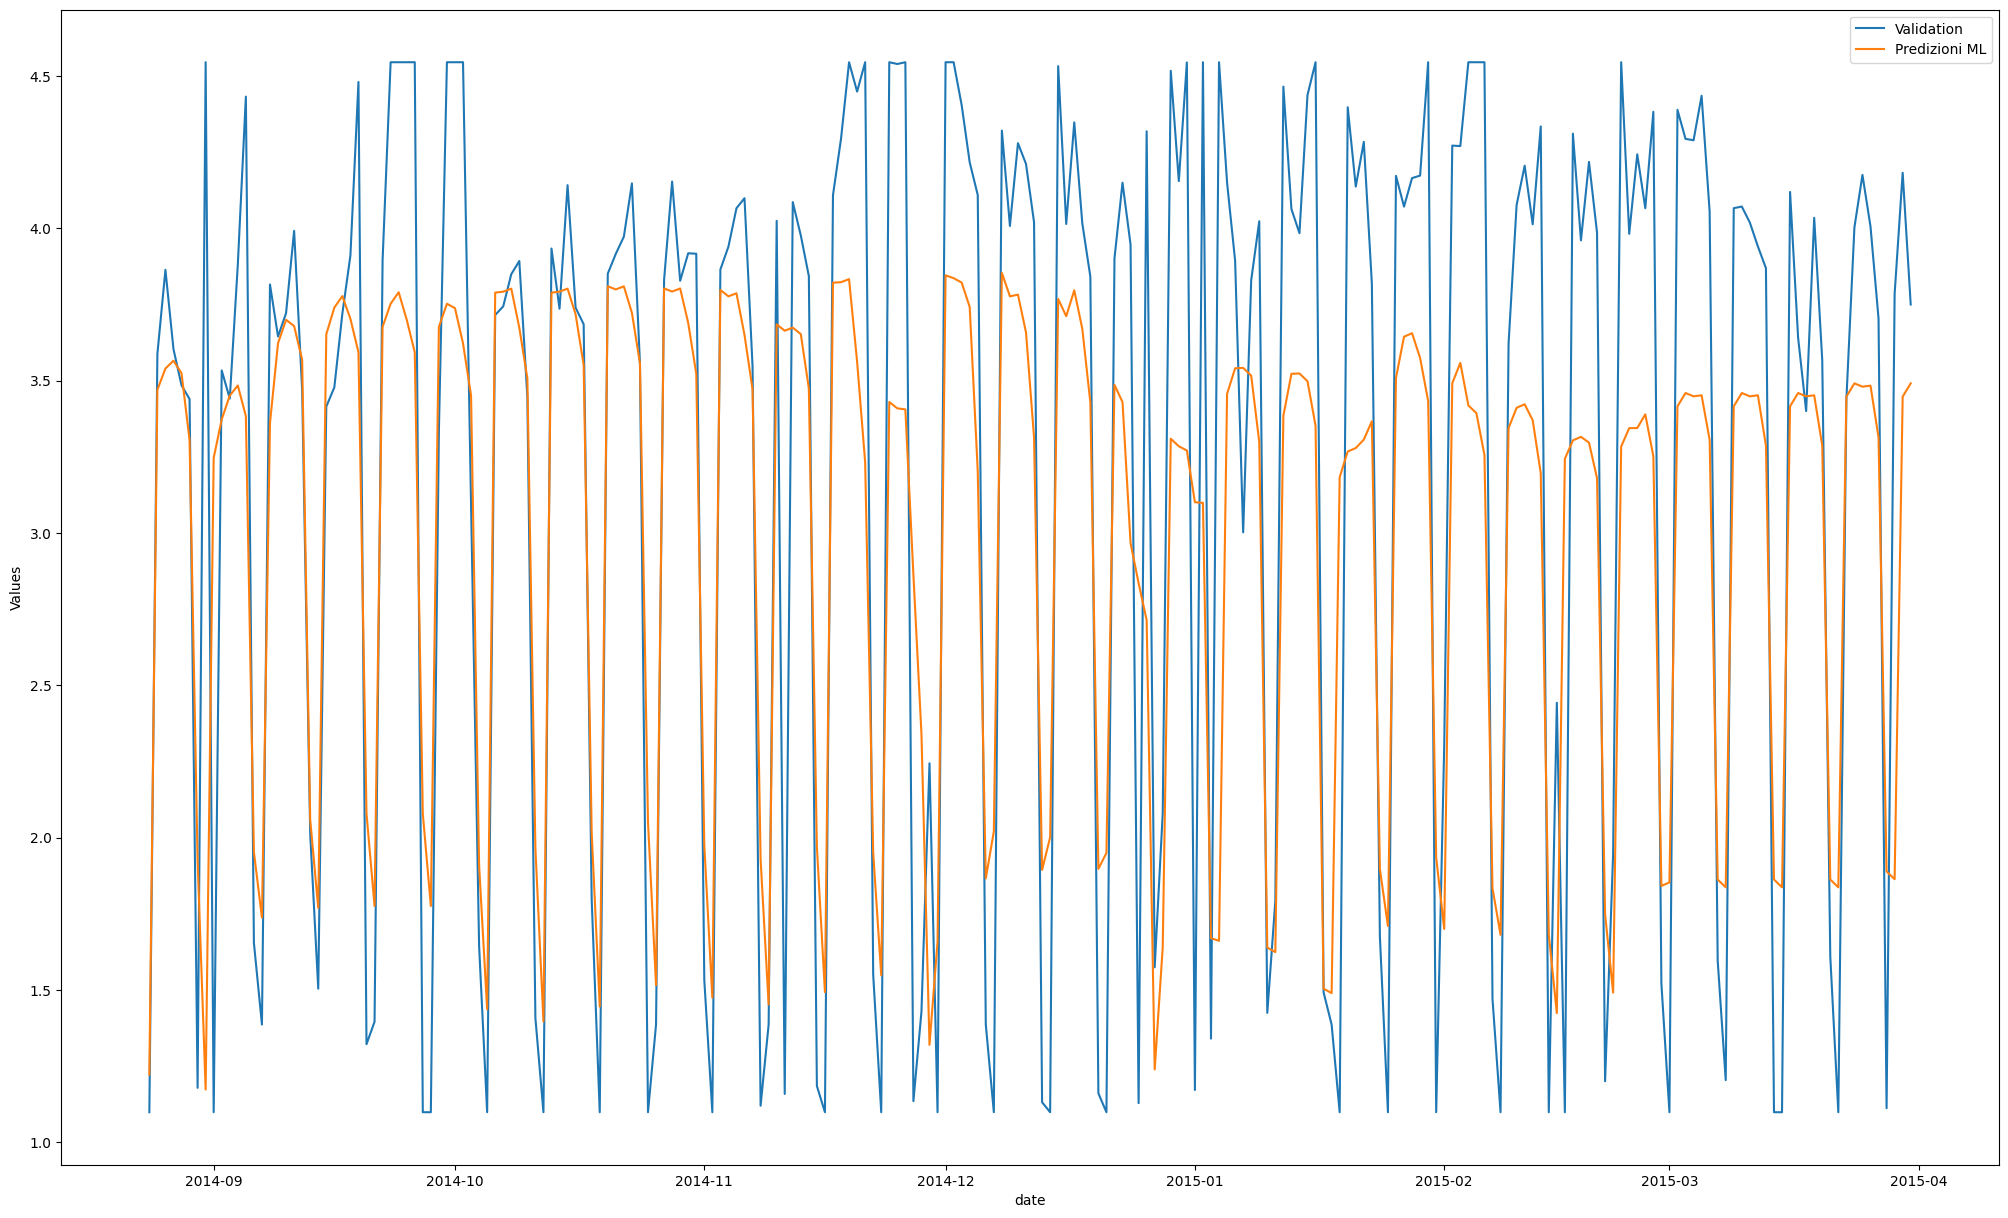

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(validation.index, validation.Value_Log, label='Validation')
plt.plot(validation.index, validation.y_pred_lightgbm, label='Predizioni ML')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Define your feature columns, holiday columns, and target variable
feature_columns = ['Num_DayofYear', 'Month', 'Num_DayofWeek', 'Num_WeekofYear', 'Quarter', "Year"]
holiday_columns = ['Is_Sunday', 'Is_Christmas', 'Is_Easter', 'Is_Last_of_Year', 'Is_Aug_15']
target_variable = 'Value_Log'

# Extract the training data
X_train = train.loc["2007-01-04": "2014-08-23", feature_columns + holiday_columns].copy()
y_train = train.loc["2007-01-04": "2014-08-23", [target_variable]].values.ravel()

# Extract the testing data
X_test = validation.loc["2014-08-24": '2015-03-31', feature_columns + holiday_columns].copy()
y_test = validation.loc["2014-08-24": '2015-03-31', [target_variable]].values.ravel()

# Assign weights to features
feature_weights = {'Num_DayofYear': 1, 'Month': 2,'Year':2, 'Num_DayofWeek': 1, 'Num_WeekofYear': 1, 'Quarter': 2,
                   'Is_Sunday': 5, 'Is_Christmas': 2, 'Is_Easter': 2, 'Is_Last_of_Year': 2, 'Is_Aug_15': 2}

# Apply feature weights to training and testing data
X_train_weighted = X_train[feature_columns + holiday_columns].replace(feature_weights)
X_test_weighted = X_test[feature_columns + holiday_columns].replace(feature_weights)

In [ ]:
X_train_weighted

Num_DayofYear  Month  Num_DayofWeek  Num_WeekofYear  Quarter  \
date                                                                       
2007-01-04              4     10              3               1       10   
2007-01-05              5     10              4               1       10   
2007-01-06              6     10              5               1       10   
2007-01-07              7     10              6               1       10   
2007-01-08              8     10              0               2       10   
...                   ...    ...            ...             ...      ...   
2014-08-19            231     80              1              34       30   
2014-08-20            232     80              2              34       30   
2014-08-21            233     80              3              34       30   
2014-08-22            234     80              4              34       30   
2014-08-23            235     80              5              34       30   

             Year  Is_Sunday  Is_Christmas  Is_Easter  Is_Last_of_Year  \
date                                                                     
2007-01-04  40140          0             0          0                0   
2007-01-05  40140          0             0          0                0   
2007-01-06  40140          0             0          0                0   
2007-01-07  40140         20             0          0                0   
2007-01-08  40140          0             0          0                0   
...           ...        ...           ...        ...              ...   
2014-08-19  40280          0             0          0                0   
2014-08-20  40280          0             0          0                0   
2014-08-21  40280          0             0          0                0   
2014-08-22  40280          0             0          0                0   
2014-08-23  40280          0             0          0                0   

            Is_Aug_15  
date                   
2007-01-04          0  
2007-01-05          0  
2007-01-06          0  
2007-01-07          0  
2007-01-08          0  
...               ...  
2014-08-19          0  
2014-08-20          0  
2014-08-21          0  
2014-08-22          0  
2014-08-23          0  

[2789 rows x 11 columns]

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# Definizione della griglia di parametri
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 10, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [123]
}

# Creazione del modello RandomForestRegressor
rf1 = RandomForestRegressor()

# Creazione di un oggetto di ricerca su griglia
rf_grid = GridSearchCV(
    estimator=rf1,
    param_grid=param_grid,
    scoring = "neg_mean_absolute_error",
    n_jobs=-1,
    cv=5
)

# Addestramento del modello sui dati
rf_grid.fit(X_train_weighted, y_train)

# Stampa dei parametri ottimali
print("I parametri ottimali sono: ", rf_grid.best_params_)

I parametri ottimali sono:  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 123}


In [ ]:
# Create and fit the model
rf_grid_best = RandomForestRegressor(
    n_estimators=150,
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features='auto',
    random_state=123
)

rf_grid_best.fit(X_train_weighted, y_train)

# Predict the test data
predictions1 = rf_grid_best.predict(X_test_weighted)

# Calculate MAE
mae_value_best1 = metrics.mean_absolute_error(predictions1, y_test)
print("MAE value is:", mae_value_best1)


MAE value is: 0.6092370442687914


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# Definizione della distribuzione casuale per i parametri
param_dist = {
    'n_estimators': sp_randint(50, 150),
    'max_depth': sp_randint(10, 50),
    'min_samples_split': sp_randint(2, 20),
    'min_samples_leaf': sp_randint(1, 20),
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [123]
}

# Creazione del modello RandomForestRegressor
rf2 = RandomForestRegressor()

# Creazione di un oggetto di ricerca casuale
rf_random = RandomizedSearchCV(
    estimator=rf2,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    random_state=123
)

# Addestramento del modello sui dati
rf_random.fit(X_train_weighted, y_train)

# Stampa dei parametri ottimali
print("I parametri ottimali sono: ", rf_random.best_params_)


I parametri ottimali sono:  {'max_depth': 37, 'max_features': 'auto', 'min_samples_leaf': 11, 'min_samples_split': 16, 'n_estimators': 71, 'random_state': 123}


In [ ]:
# Create and fit the model
rf_random_best = RandomForestRegressor(
    n_estimators=80,
    max_depth=30,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='auto',
    random_state=123
)

rf_random_best.fit(X_train_weighted, y_train)

# Predict the test data
predictions2 = rf_random_best.predict(X_test_weighted)

# Calculate MAE
mae_value_best2 = metrics.mean_absolute_error(predictions2, y_test)
print("MAE value is:", mae_value_best2)


MAE value is: 0.5839126664902918


In [ ]:
X_train_weighted

Num_DayofYear  Month  Num_DayofWeek  Num_WeekofYear  Quarter  \
date                                                                       
2007-01-04              4      1              3               1        1   
2007-01-05              5      1              4               1        1   
2007-01-06              6      1              5               1        1   
2007-01-07              7      1              6               1        1   
2007-01-08              8      1              0               2        1   
...                   ...    ...            ...             ...      ...   
2014-08-19            231      8              1              34        3   
2014-08-20            232      8              2              34        3   
2014-08-21            233      8              3              34        3   
2014-08-22            234      8              4              34        3   
2014-08-23            235      8              5              34        3   

            Year  Is_Sunday  Is_Christmas  Is_Easter  Is_Last_of_Year  \
date                                                                    
2007-01-04  2007          0             0          0                0   
2007-01-05  2007          0             0          0                0   
2007-01-06  2007          0             0          0                0   
2007-01-07  2007          1             0          0                0   
2007-01-08  2007          0             0          0                0   
...          ...        ...           ...        ...              ...   
2014-08-19  2014          0             0          0                0   
2014-08-20  2014          0             0          0                0   
2014-08-21  2014          0             0          0                0   
2014-08-22  2014          0             0          0                0   
2014-08-23  2014          0             0          0                0   

            Is_Aug_15  
date                   
2007-01-04          0  
2007-01-05          0  
2007-01-06          0  
2007-01-07          0  
2007-01-08          0  
...               ...  
2014-08-19          0  
2014-08-20          0  
2014-08-21          0  
2014-08-22          0  
2014-08-23          0  

[2789 rows x 11 columns]

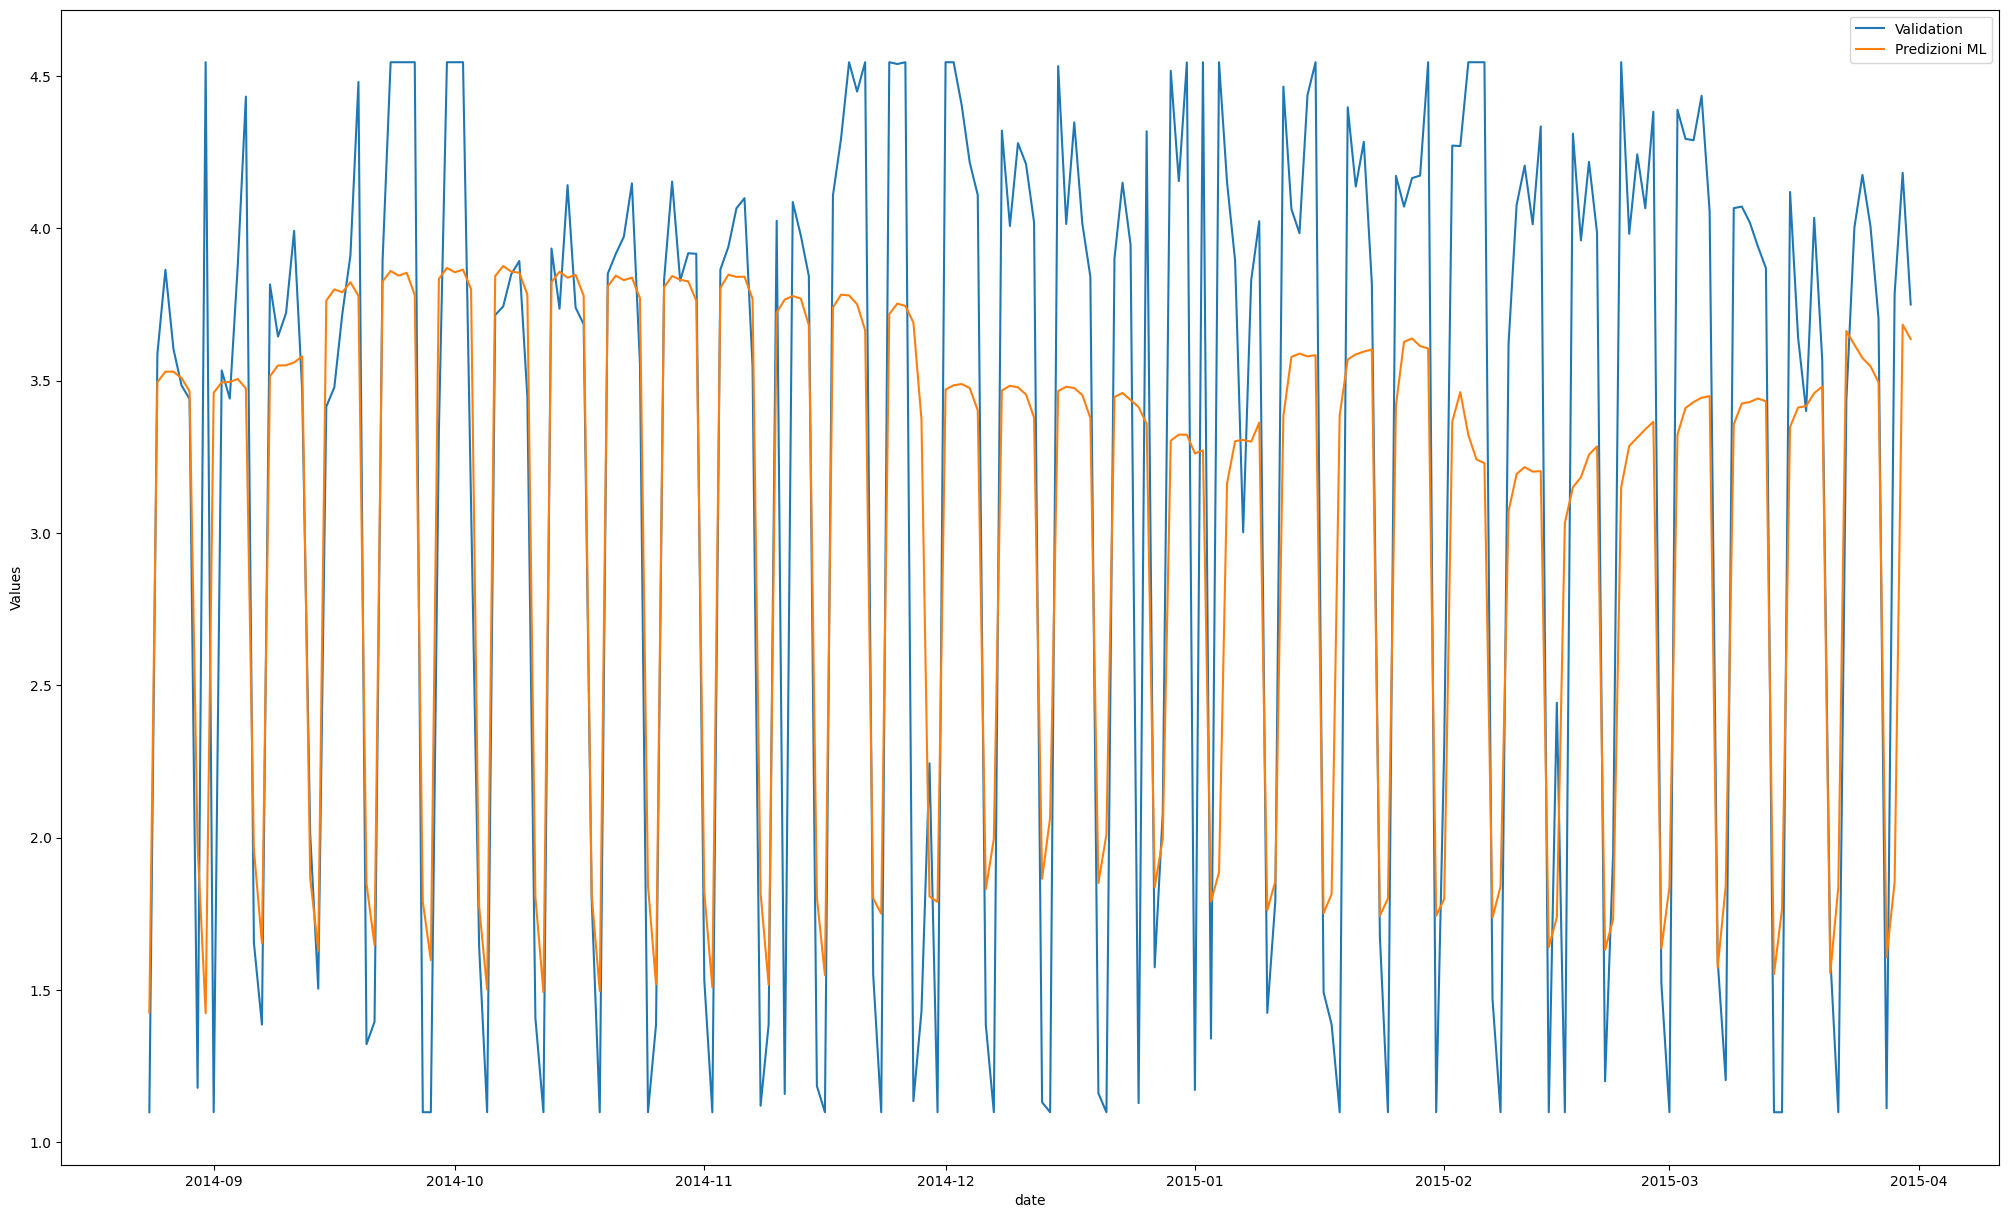

In [ ]:
fig = plt.figure(figsize=(25, 15))
plt.plot(validation.index, validation.Value_Log, label='Validation')
plt.plot(validation.index, predictions1, label='Predizioni ML')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()

### Prediction fino al 2015-11-07

In [ ]:
import pandas as pd

# Assuming your trained model is named rf_grid_best

# Define the period for forecasting
forecast_start_date = "2015-04-01"
forecast_end_date = "2015-11-07"

# Create a DataFrame with the dates for forecasting
forecast_dates = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='D')
forecast_data = pd.DataFrame(index=forecast_dates, columns=feature_columns + holiday_columns)

In [ ]:
forecast_data['Year'] = forecast_data.index.year
forecast_data['Month'] = forecast_data.index.month
forecast_data['Day'] = forecast_data.index.day
forecast_data['Month_Name'] = forecast_data.index.strftime("%B")

forecast_data['Num_DayofYear'] = forecast_data.index.dayofyear
forecast_data['Num_DayofWeek'] = forecast_data.index.dayofweek
forecast_data['Num_WeekofYear'] = forecast_data.index.isocalendar().week

forecast_data['Quarter'] = forecast_data.index.quarter

forecast_data['Just_Date'] = forecast_data.index.date

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Assuming your time series data is stored in a DataFrame called df
# and 'date' column is already in datetime format

# Create dummy columns for holidays
forecast_data['Is_Sunday'] = (forecast_data['Num_DayofWeek'] == 6).astype(int)

# Christmas (December 25th)
forecast_data['Is_Christmas'] = ((forecast_data['Month'] == 12) & (forecast_data['Day'] == 25)).astype(int)
forecast_data['Is_Christmas'] = ((forecast_data['Month'] == 12) & (forecast_data['Day'] == 24)).astype(int)
forecast_data['Is_Christmas'] = ((forecast_data['Month'] == 12) & (forecast_data['Day'] == 26)).astype(int)

# Easter (This is a simplified example, actual calculation might be more complex)
# Easter is usually the first Sunday after the first full moon after March 21st
# You may need to use a library or a more detailed calculation for accurate results
forecast_data['Is_Easter'] = ((forecast_data['Month'] == 3) & (forecast_data['Day'] >= 21) & (forecast_data['Num_DayofWeek'] == 6)).astype(int)

# Last day of the year (December 31st)
forecast_data['Is_Last_of_Year'] = ((forecast_data['Month'] == 12) & (forecast_data['Day'] == 31)).astype(int)

# August 15th
forecast_data['Is_Aug_15'] = ((forecast_data['Month'] == 8) & (forecast_data['Day'] == 15)).astype(int)

# Print the DataFrame to check the new columns
print(forecast_data)

            Num_DayofYear  Month  Num_DayofWeek  Num_WeekofYear  Quarter  \
2015-04-01             91      4              2              14        2   
2015-04-02             92      4              3              14        2   
2015-04-03             93      4              4              14        2   
2015-04-04             94      4              5              14        2   
2015-04-05             95      4              6              14        2   
...                   ...    ...            ...             ...      ...   
2015-11-03            307     11              1              45        4   
2015-11-04            308     11              2              45        4   
2015-11-05            309     11              3              45        4   
2015-11-06            310     11              4              45        4   
2015-11-07            311     11              5              45        4   

            Year  Is_Sunday  Is_Christmas  Is_Easter  Is_Last_of_Year  \
2015-04-01  20

In [ ]:
# Assign weights to features
feature_weights = {'Num_DayofYear': 1, 'Month': 1.2, 'Num_DayofWeek': 1.5, 'Num_WeekofYear': 0.5, 'Quarter': 1.5,
                   'Is_Sunday': 5, 'Is_Christmas': 1, 'Is_Easter': 0.5, 'Is_Last_of_Year': 1, 'Is_Aug_15': 1}

# Apply feature weights to forecast data
forecast_data_weighted = forecast_data.replace(feature_weights)

# Fill missing values with zeros
forecast_data_weighted = forecast_data_weighted.fillna(1)

columns_to_drop = ['Day', 'Just_Date', 'Month_Name']
forecast_data_weighted = forecast_data_weighted.drop(columns=columns_to_drop, errors='ignore')

# Make predictions for the forecast period
forecast_predictions = rf_grid_best.predict(forecast_data_weighted)

# Create a DataFrame to store the forecast results
forecast_results = pd.DataFrame(index=forecast_dates)
forecast_results['Predicted_Values'] = forecast_predictions

# Print or use the forecast_results DataFrame as needed
print(forecast_results)


            Predicted_Values
2015-04-01          3.583423
2015-04-02          3.553607
2015-04-03          3.498283
2015-04-04          1.582004
2015-04-05          1.553486
...                      ...
2015-11-03          3.844219
2015-11-04          3.839992
2015-11-05          3.838646
2015-11-06          3.768212
2015-11-07          1.817143

[221 rows x 1 columns]


In [ ]:
# Unlog the predictions
ML = np.exp(forecast_results)

In [ ]:
ML

Predicted_Values
2015-04-01         35.969957
2015-04-02         34.908183
2015-04-03         32.877855
2015-04-04          4.869263
2015-04-05          4.708049
...                      ...
2015-11-03         46.750242
2015-11-04         46.533143
2015-11-05         46.470562
2015-11-06         43.082633
2015-11-07          6.141107

[221 rows x 1 columns]

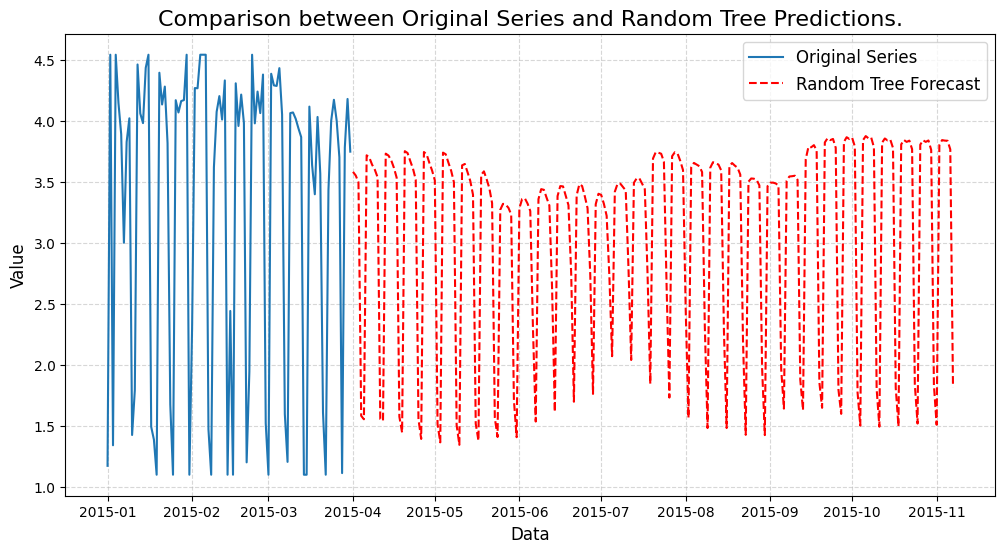

In [ ]:
import matplotlib.pyplot as plt

# Estrai gli ultimi 3 mesi della serie originale
last_3_months_original = serie_arima.index[-90:]
last_3_months_values = serie_arima[-90:]

# Unisci la serie originale con le previsioni del modello SARIMA
combined_df = pd.concat([last_3_months_values, forecast_results], axis=1)

# Plot della serie originale e delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df.iloc[:, 0], label='Original Series')
plt.plot(combined_df.index, combined_df.iloc[:, 1], label='Random Tree Forecast', color='red', linestyle='dashed')

# Imposta i titoli e le etichette degli assi
plt.title('Comparison between Original Series and Random Tree Predictions.', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Aggiungi una legenda
plt.legend(fontsize=12)

# Aggiungi una griglia
plt.grid(True, linestyle='--', alpha=0.5)

# Mostra il plot
plt.show()


# ARIMA

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00


In [ ]:
train_arima = train[['Value_Log', 'Year', 'Month', 'Day','Quarter', 'Is_Sunday', 'Is_Christmas', 'Is_Easter', 'Is_Last_of_Year', 'Is_Aug_15']]

In [ ]:
y_train = train_arima['Value_Log']

In [ ]:
y_test = validation['Value_Log']

In [ ]:
y_train

date
2007-01-04    0.779090
2007-01-05    0.916291
2007-01-06    1.098612
2007-01-07    1.098612
2007-01-08    1.708693
                ...   
2014-08-19    3.438637
2014-08-20    3.746222
2014-08-21    3.633876
2014-08-22    3.233527
2014-08-23    4.277722
Name: Value_Log, Length: 2789, dtype: float64

In [ ]:
from pmdarima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error

# Cerca automaticamente i parametri ottimali per il modello ARIMA
model = auto_arima(y_train, seasonal=True, m=7, trace=True)

# Stampa i parametri ottimali
print("Parametri Ottimali:", model.get_params())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=63.55 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9202.673, Time=0.23 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8071.625, Time=2.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7497.840, Time=3.24 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9200.676, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8039.737, Time=1.56 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=10.06 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=7230.590, Time=9.37 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=24.78 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=8618.512, Time=1.75 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=7160.272, Time=12.21 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=7393.587, Time=5.33 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=6275.232, Time=22.24 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=6331.094, Time=9.03 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=i

## Model 1

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


model1_ARIMA = SARIMAX(y_train, maxiter = 50, method = 'lbfgs', order=(1, 1, 1), seasonal_order=(1, 0, 2, 21), enforce_stationarity=False, enforce_invertibility=False, scoring = 'mae')


fit1 = model1_ARIMA.fit()

# Ottieni le previsioni sul set di test
forecast_values = fit1.predict(start=y_test.index[0], end=y_test.index[-1], dynamic=False)

# Calcola le metriche di performance sul set di test
mae_test = mean_absolute_error(y_test, forecast_values)
mse_test = mean_squared_error(y_test, forecast_values)
rmse_test = sqrt(mse_test)

# Stampa le metriche di performance sul set di test
print('Metrics on Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)

# Stampa un riepilogo del modello ARIMA
print(fit1.summary())

Metrics on Test Set:
MAE: 0.5829870693840585
MSE: 0.640583950605909
RMSE: 0.8003648859151112
                                        SARIMAX Results                                        
Dep. Variable:                               Value_Log   No. Observations:                 2789
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 21)   Log Likelihood               -3151.622
Date:                                 Fri, 16 Feb 2024   AIC                           6315.244
Time:                                         14:10:09   BIC                           6350.747
Sample:                                     01-04-2007   HQIC                          6328.072
                                          - 08-23-2014                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [ ]:
forecast_values_mod1 = forecast_values

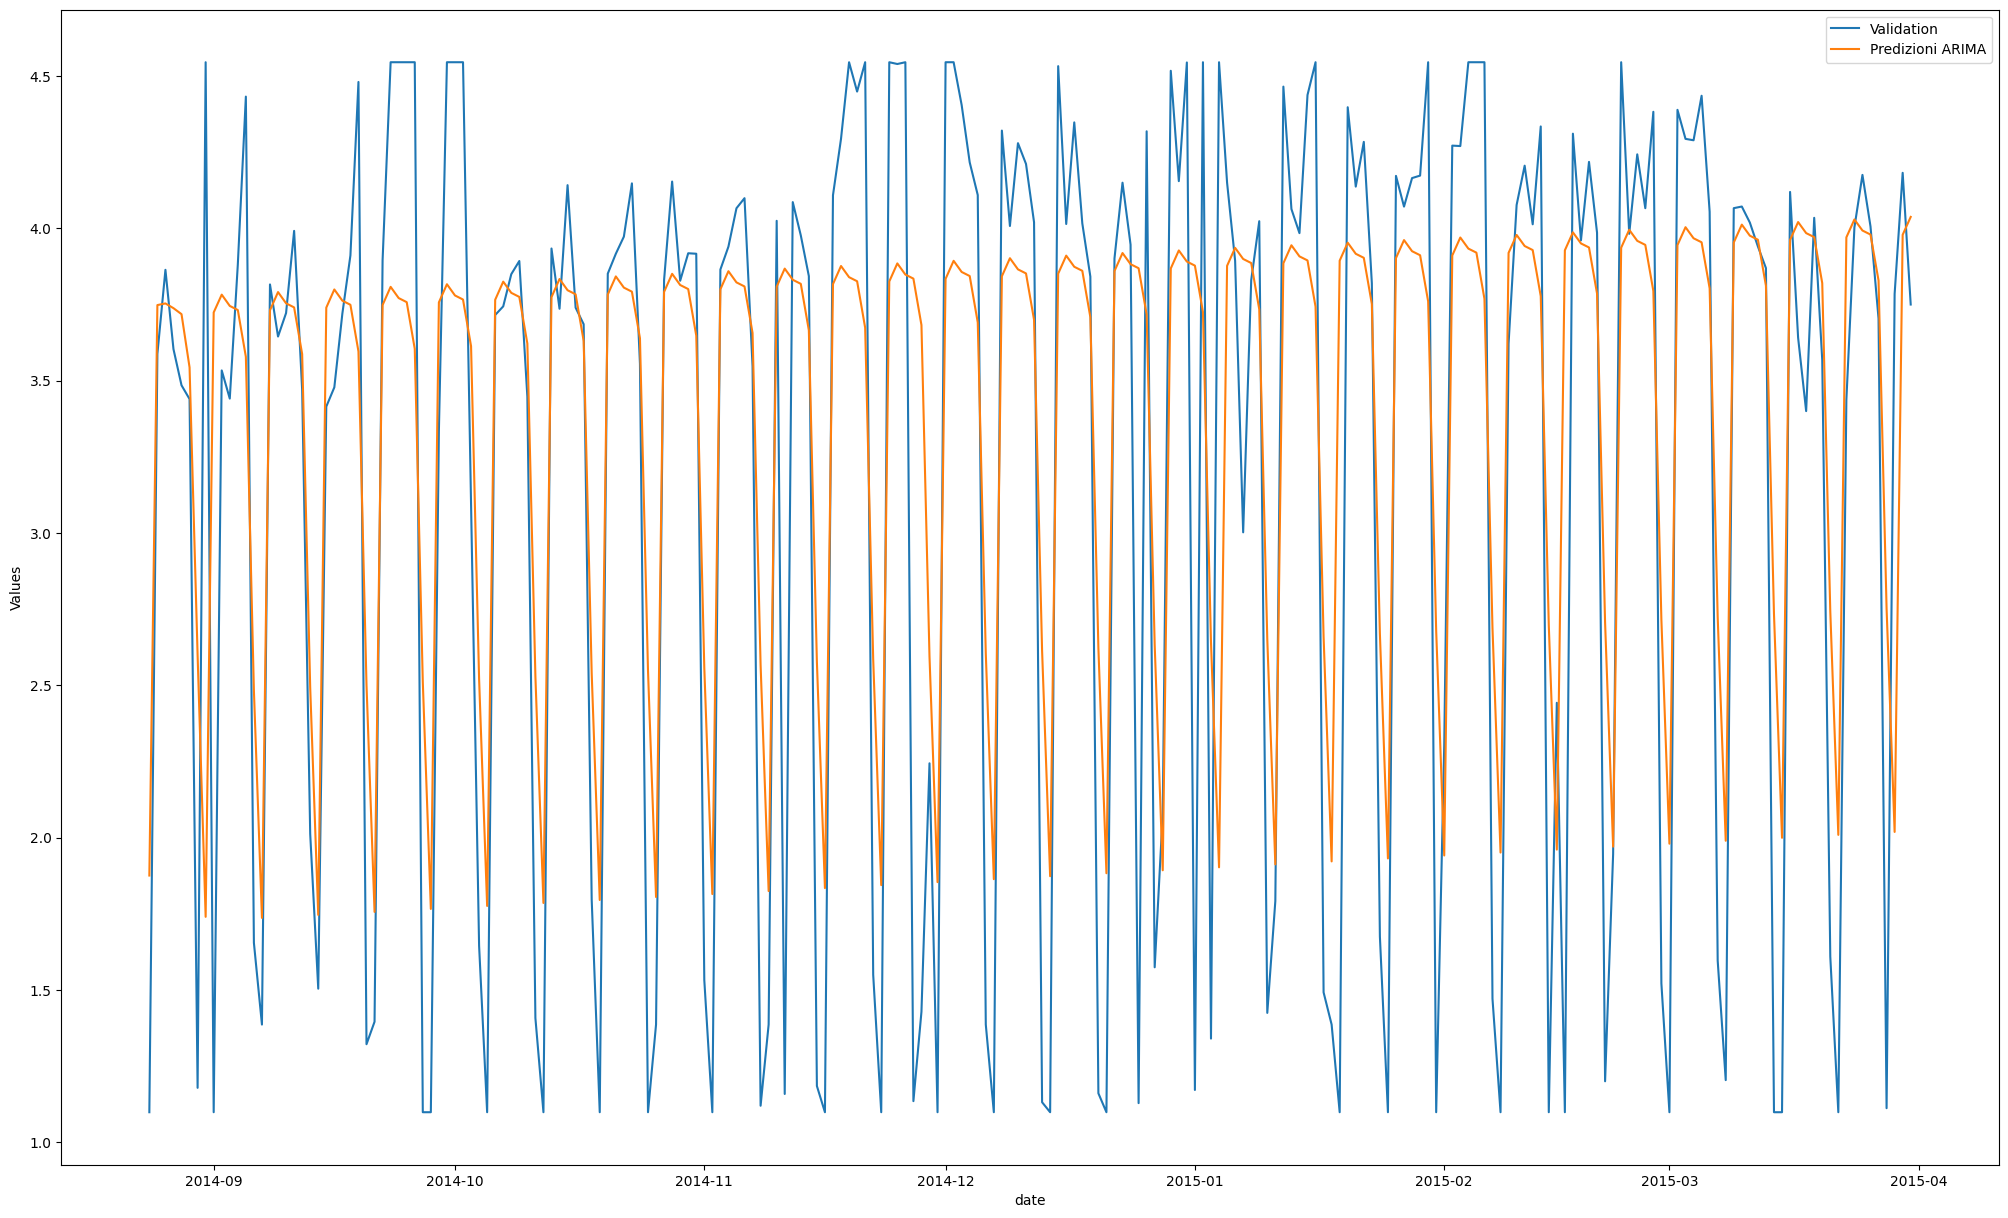

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(validation.index, validation.Value_Log, label='Validation')
plt.plot(validation.index, forecast_values, label='Predizioni ARIMA')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()

In [ ]:
residuals = fit1.resid

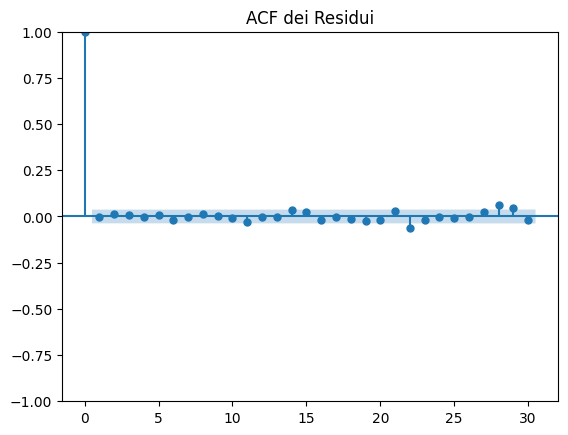

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=30)
plt.title('ACF dei Residui')
plt.show()

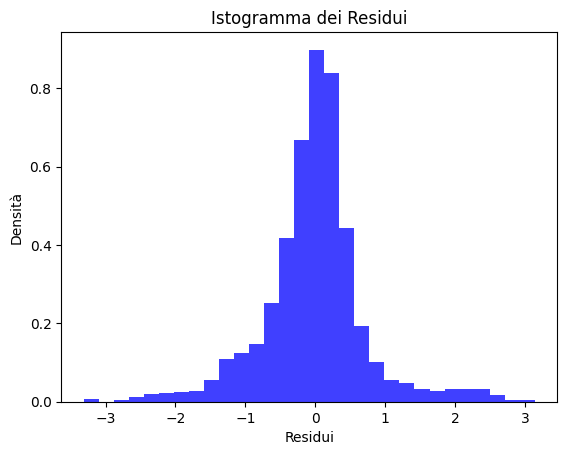

In [ ]:
plt.hist(residuals, bins=30, density=True, alpha=0.75, color='b')
plt.title('Istogramma dei Residui')
plt.xlabel('Residui')
plt.ylabel('Densità')
plt.show()


## Model 2

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


model2_ARIMA = SARIMAX(y_train, maxiter = 50, method = 'lbfgs', order = (1, 1, 1),  seasonal_order = (2, 0, 1, 7), start_params= None, suppress_warnings= True, trend= None, with_intercept= True)


fit2 = model2_ARIMA.fit()

# Ottieni le previsioni sul set di test
forecast_values_mod2 = fit2.predict(start=y_test.index[0], end=y_test.index[-1], dynamic=False)

# Calcola le metriche di performance sul set di test
mae_test = mean_absolute_error(y_test, forecast_values_mod2)
mse_test = mean_squared_error(y_test, forecast_values_mod2)
rmse_test = sqrt(mse_test)

# Stampa le metriche di performance sul set di test
print('Metrics on Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)



Metrics on Test Set:
MAE: 0.6164066683018545
MSE: 0.7480153083489139
RMSE: 0.8648787824596658


In [ ]:
forecast_values_mod2

2014-08-24    1.902837
2014-08-25    3.734930
2014-08-26    3.731133
2014-08-27    3.721454
2014-08-28    3.700801
                ...   
2015-03-27    3.789334
2015-03-28    2.794830
2015-03-29    2.095446
2015-03-30    3.932290
2015-03-31    3.984611
Freq: D, Name: predicted_mean, Length: 220, dtype: float64

## Model 3

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


model3_ARIMA = SARIMAX(y_train, maxiter = 50, method = 'lbfgs', order=(2, 1, 3), seasonal_order=(2, 2, 3, 21), enforce_stationarity=False, enforce_invertibility=False, scoring = 'mse')


fit3 = model3_ARIMA.fit()

# Ottieni le previsioni sul set di test
forecast_values_mod3 = fit3.predict(start=y_test.index[0], end=y_test.index[-1], dynamic=False)

# Calcola le metriche di performance sul set di test
mae_test = mean_absolute_error(y_test, forecast_values_mod3)
mse_test = mean_squared_error(y_test, forecast_values_mod3)
rmse_test = sqrt(mse_test)

# Stampa le metriche di performance sul set di test
print('Metrics on Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)

# Stampa un riepilogo del modello ARIMA
print(fit3.summary())

Metrics on Test Set:
MAE: 0.5745375709202886
MSE: 0.6489047165536193
RMSE: 0.8055462224811306
                                     SARIMAX Results                                      
Dep. Variable:                          Value_Log   No. Observations:                 2789
Model:             SARIMAX(2, 1, 3)x(2, 2, 3, 21)   Log Likelihood               -3178.659
Date:                            Fri, 16 Feb 2024   AIC                           6379.317
Time:                                    14:30:19   BIC                           6444.143
Sample:                                01-04-2007   HQIC                          6402.769
                                     - 08-23-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.064

In [ ]:
residuals = fit3.resid

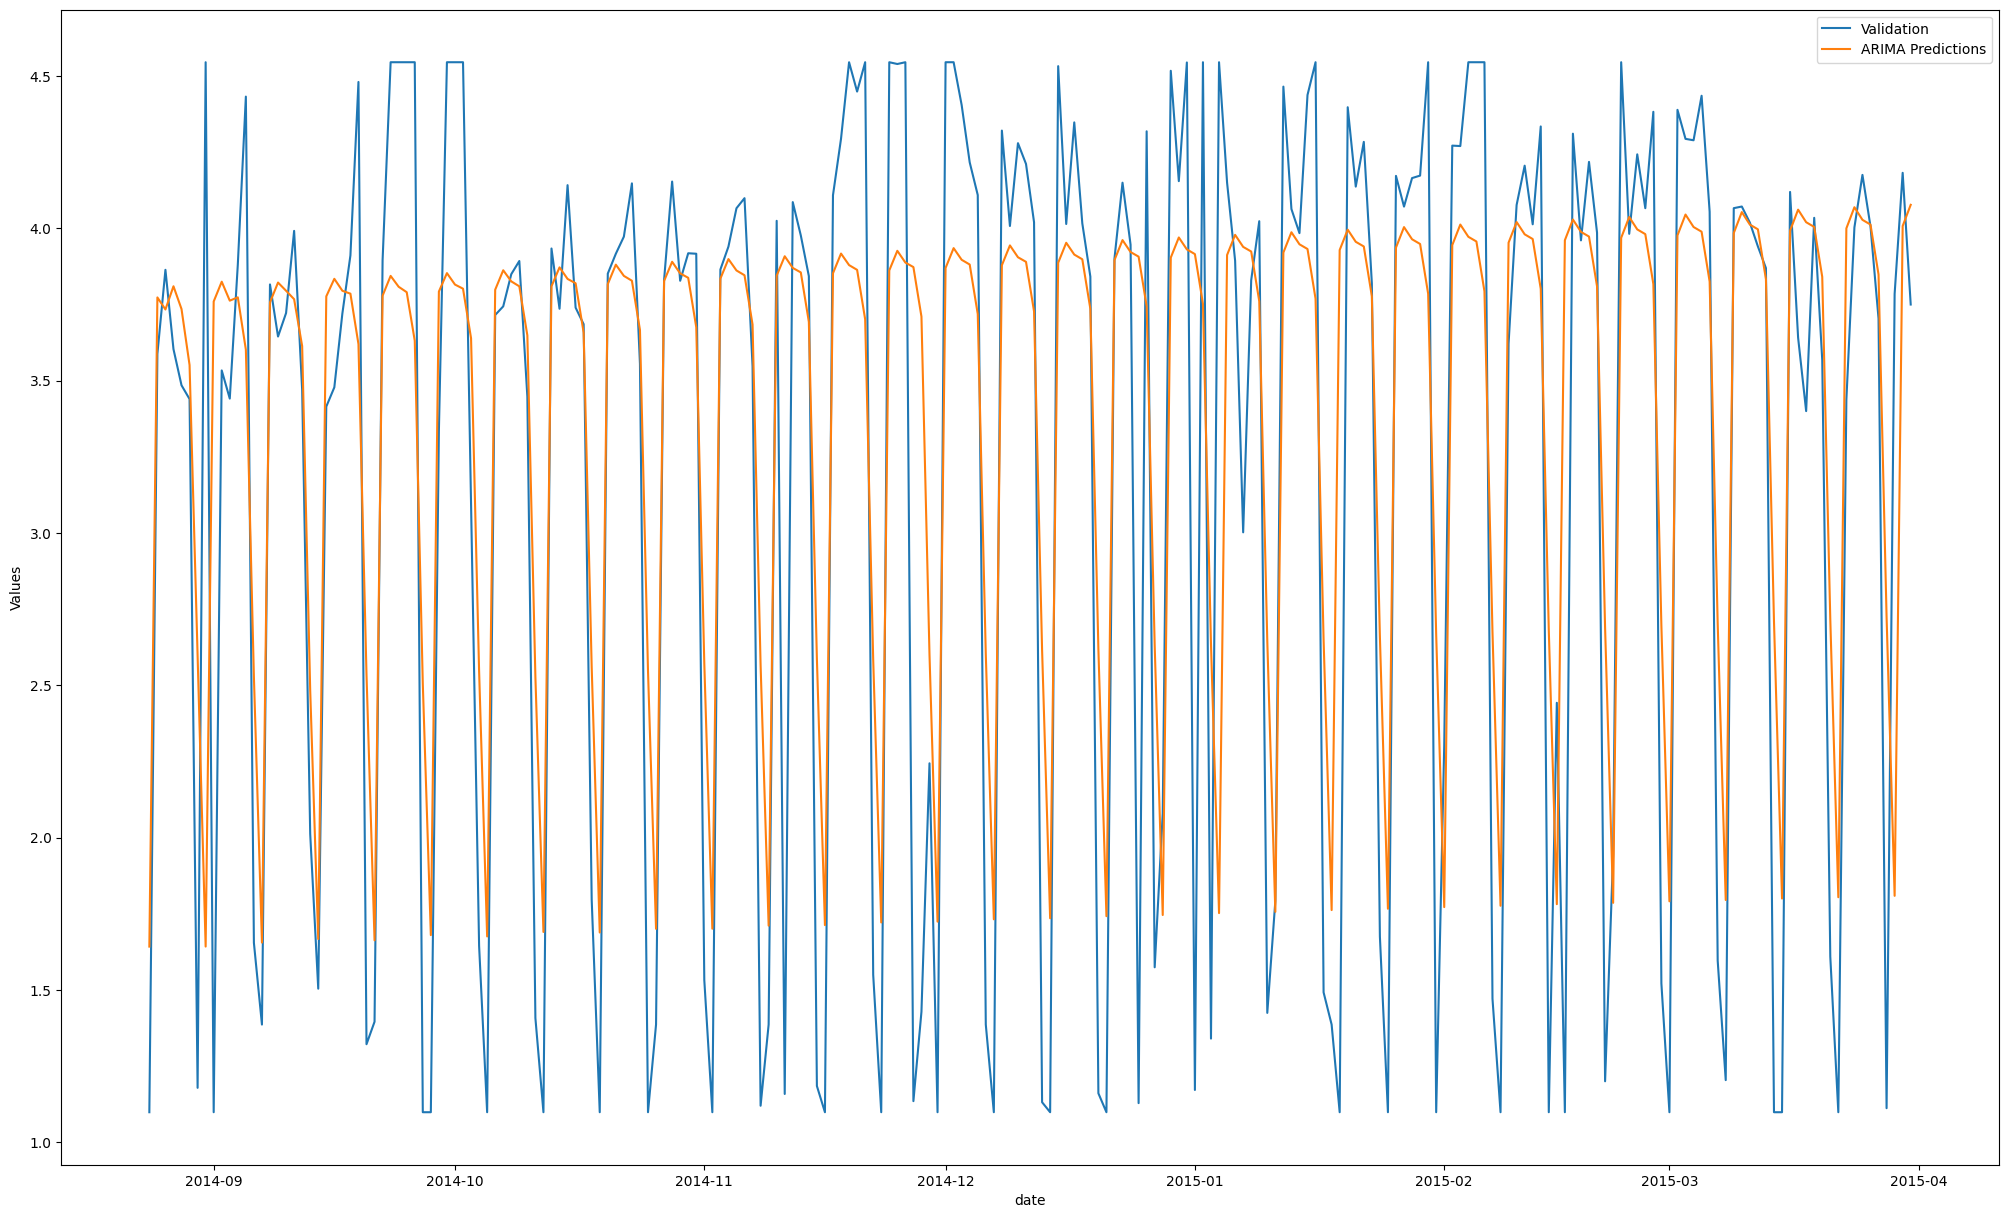

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(validation.index, validation.Value_Log, label='Validation')
plt.plot(validation.index, forecast_values_mod3, label='ARIMA Predictions')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()

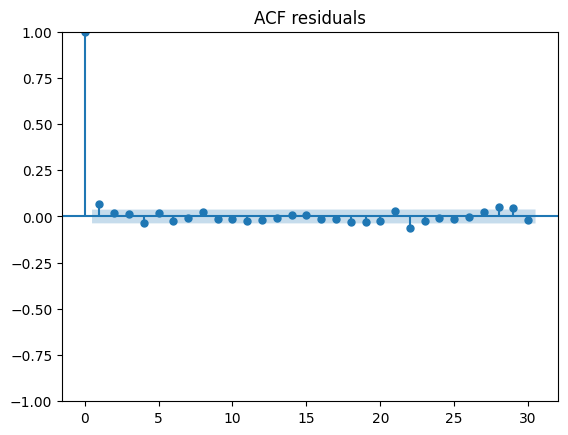

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals, lags=30)
plt.title('ACF residuals')
plt.show()

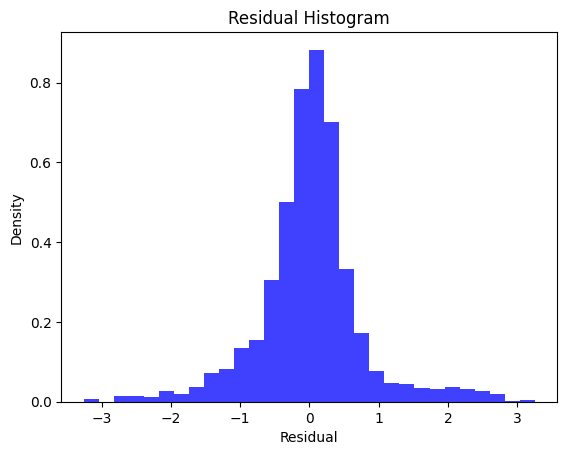

In [ ]:
plt.hist(residuals, bins=30, density=True, alpha=0.75, color='b')
plt.title('Residual Histogram')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.show()

## Model 4

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt


model4_ARIMA = SARIMAX(y_train, maxiter = 50, method = 'lbfgs', order=(0, 1, 1), seasonal_order=(0, 0, 2, 7), enforce_stationarity=False, enforce_invertibility=False)


fit4 = model4_ARIMA.fit()

# Ottieni le previsioni sul set di test
forecast_values_mod4 = fit4.predict(start=y_test.index[0], end=y_test.index[-1], dynamic=False)

# Calcola le metriche di performance sul set di test
mae_test = mean_absolute_error(y_test, forecast_values_mod4)
mse_test = mean_squared_error(y_test, forecast_values_mod4)
rmse_test = sqrt(mse_test)

# Stampa le metriche di performance sul set di test
print('Metrics on Test Set:')
print('MAE:', mae_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)

# Stampa un riepilogo del modello ARIMA
print(fit4.summary())

Metrics on Test Set:
MAE: 1.1872895630145779
MSE: 1.7008559785020199
RMSE: 1.3041686925018634
                                       SARIMAX Results                                        
Dep. Variable:                              Value_Log   No. Observations:                 2789
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -3595.123
Date:                                Fri, 16 Feb 2024   AIC                           7198.247
Time:                                        11:46:57   BIC                           7221.956
Sample:                                    01-04-2007   HQIC                          7206.809
                                         - 08-23-2014                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

### Prediction

In [ ]:
serie_arima = data['Value_Log']

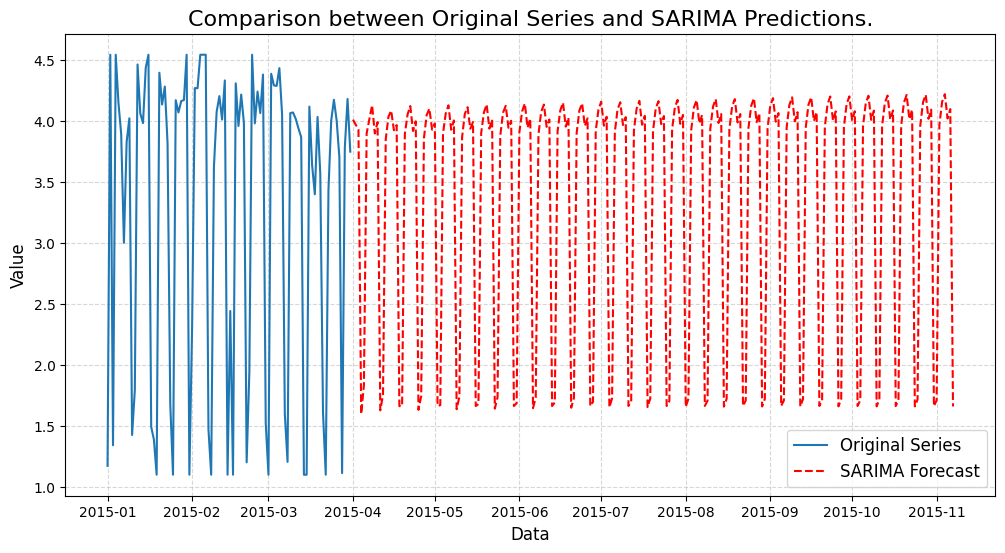

In [ ]:
import matplotlib.pyplot as plt

# Estrai gli ultimi 3 mesi della serie originale
last_3_months_original = serie_arima.index[-90:]
last_3_months_values = serie_arima[-90:]

# Unisci la serie originale con le previsioni del modello SARIMA
combined_df = pd.concat([last_3_months_values, forecast_mean_sarima], axis=1)

# Plot della serie originale e delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df.iloc[:, 0], label='Original Series')
plt.plot(combined_df.index, combined_df.iloc[:, 1], label='SARIMA Forecast', color='red', linestyle='dashed')

# Imposta i titoli e le etichette degli assi
plt.title('Comparison between Original Series and SARIMA Predictions.', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Aggiungi una legenda
plt.legend(fontsize=12)

# Aggiungi una griglia
plt.grid(True, linestyle='--', alpha=0.5)

# Mostra il plot
plt.show()


In [ ]:
model_ARIMA = SARIMAX(serie_arima, maxiter = 50, method = 'lbfgs',order=(2, 1, 3), seasonal_order=(2, 2, 3, 7), enforce_stationarity=False, enforce_invertibility=False, scoring = 'mae')

fit_ARIMA = model_ARIMA.fit()
# Specifica le date di inizio e fine per le previsioni
start_date = '2015-04-01'
end_date = '2015-11-07'

# Crea un indice temporale per il periodo di previsione
forecast_index_sarima = pd.date_range(start=start_date, end=end_date, freq='D')  # frequenza giornaliera

forecast_values_sarima = fit_ARIMA.get_forecast(steps=len(forecast_index_sarima))
forecast_mean_sarima = forecast_values_sarima.predicted_mean
forecast_ci_sarima = forecast_values_sarima.conf_int()

# Crea un DataFrame con le previsioni
forecast_df_sarima = pd.DataFrame(data={'ARIMA': forecast_mean_sarima}, index=forecast_index_sarima)

# Visualizza il DataFrame con le previsioni
print(forecast_df_sarima)


               ARIMA
2015-04-01  4.011904
2015-04-02  3.970314
2015-04-03  3.931013
2015-04-04  1.596012
2015-04-05  1.832041
...              ...
2015-11-03  4.157961
2015-11-04  4.220935
2015-11-05  4.021339
2015-11-06  4.098584
2015-11-07  1.658737

[221 rows x 1 columns]


# UCM

In [ ]:
train = data.loc[ "2007-01-04": "2014-08-23"]
validation = data.loc["2014-08-24" : ]

In [ ]:
df = pd.DataFrame({'date': data.index, 'ave_days_filled': data.Value_Log})
# Converti la colonna 'date' in tipo datetime

# Verifica il tipo di dati ottenuto
print(df.dtypes)

# Verifica il DataFrame
print(df)

date               datetime64[ns]
ave_days_filled           float64
dtype: object
                 date  ave_days_filled
date                                  
2007-01-04 2007-01-04         0.779090
2007-01-05 2007-01-05         0.916291
2007-01-06 2007-01-06         1.098612
2007-01-07 2007-01-07         1.098612
2007-01-08 2007-01-08         1.708693
...               ...              ...
2015-03-27 2015-03-27         3.703294
2015-03-28 2015-03-28         1.111858
2015-03-29 2015-03-29         3.784190
2015-03-30 2015-03-30         4.181701
2015-03-31 2015-03-31         3.749426

[3009 rows x 2 columns]


In [ ]:
df.set_index(df['date'], inplace = True)

In [ ]:
df.drop(columns=['date'])

ave_days_filled
date                       
2007-01-04         0.779090
2007-01-05         0.916291
2007-01-06         1.098612
2007-01-07         1.098612
2007-01-08         1.708693
...                     ...
2015-03-27         3.703294
2015-03-28         1.111858
2015-03-29         3.784190
2015-03-30         4.181701
2015-03-31         3.749426

[3009 rows x 1 columns]

In [ ]:
train = df.loc[ "2007-01-04": "2014-08-23"]
test = df.loc["2014-08-24" : ]

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from itertools import product

serie = pd.Series(df['ave_days_filled'])

train = pd.Series(train['ave_days_filled'])
test = pd.Series(test['ave_days_filled'])
# # Suddivide la serie in train e test
# split_index = int(len(serie) * 0.8)
# train, test = serie[:split_index], serie[split_index:]

# Definisci i possibili valori dei parametri da testare
levels = [True, False]
trends = [True, False]
seasonals = [True, False]
stochastic_levels = [True, False]
stochastic_trends = [True, False]
stochastic_seasonals = [True, False]

# Inizializza variabili per tenere traccia della miglior configurazione
best_rmse = float('inf')
best_params = None

# Prova tutte le combinazioni di parametri
for params in product(levels, trends, seasonals, stochastic_levels, stochastic_trends, stochastic_seasonals):
    level, trend, seasonal, stochastic_level, stochastic_trend, stochastic_seasonal = params

    # Se la stagionalità è attivata, aggiungi un loop per testare diverse lunghezze del periodo stagionale
    if seasonal:
        for seasonal_periods in range(28,28):
            # Crea e addestra il modello con i parametri correnti
            model = sm.tsa.UnobservedComponents(train, level=level, trend=trend, seasonal=seasonal,
                                                seasonal_periods=seasonal_periods,
                                                stochastic_level=stochastic_level, stochastic_trend=stochastic_trend,
                                                stochastic_seasonal=stochastic_seasonal)
            result = model.fit()

            # Valuta il modello
            forecast = result.get_forecast(steps=len(test))
            predicted_mean = forecast.predicted_mean
            rmse = mean_squared_error(test, predicted_mean, squared=False)

            # Aggiorna la miglior configurazione se necessario
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params + (seasonal_periods,)

    else:
        # Crea e addestra il modello con i parametri correnti
        model = sm.tsa.UnobservedComponents(train, level=level, trend=trend, seasonal=seasonal,
                                            stochastic_level=stochastic_level, stochastic_trend=stochastic_trend,
                                            stochastic_seasonal=stochastic_seasonal)
        result = model.fit()

        # Valuta il modello
        forecast = result.get_forecast(steps=len(test))
        predicted_mean = forecast.predicted_mean
        rmse = mean_squared_error(test, predicted_mean, squared=False)

        # Aggiorna la miglior configurazione se necessario
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

print(f"Migliori parametri: {best_params}")
print(f"Miglior RMSE: {best_rmse}")



Migliori parametri: (True, False, False, False, True, True)
Miglior RMSE: 1.3068944622627028


In [ ]:
# (level=True, trend=False, seasonal=False, stochastic_level=False, stochastic_trend=True, stochastic_seasonal=True))

## Model 1 - Local Level

In [ ]:
import statsmodels.api as sm


model1_UCM = sm.tsa.UnobservedComponents(train, 'llevel', trend=True, seasonal=21, stochastic_level=False, stochastic_trend=True, stochastic_seasonal=True)

# Fit del modello
result1 = model1_UCM.fit()

# Stampa un riepilogo dei risultati
print(result1.summary())

# Valuta il modello sui dati di test
forecast_mod1 = result1.get_forecast(steps=len(test))
predicted_mean = forecast_mod1.predicted_mean
rmse = np.sqrt(((predicted_mean - test) ** 2).mean())
print(f"RMSE sul set di test: {rmse}")


                            Unobserved Components Results                            
Dep. Variable:               ave_days_filled   No. Observations:                 2789
Model:                           local level   Log Likelihood               -3183.076
                   + stochastic seasonal(21)   AIC                           6372.152
Date:                       Fri, 16 Feb 2024   BIC                           6389.930
Time:                               14:05:19   HQIC                          6378.573
Sample:                           01-04-2007                                         
                                - 08-23-2014                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.5195      0.010     54.380      0

In [ ]:
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score,mean_squared_error

# Calcola le metriche
mae_ucm = mean_absolute_error(test, predicted_mean)
mse_ucm = mean_squared_error(test, predicted_mean)

# Stampa le metriche
print('UCM Metrics on Validation Set:')
print('MAE:', mae_ucm)
print('MSE:', mse_ucm)


UCM Metrics on Validation Set:
MAE: 0.6072311826350638
MSE: 0.6602709780913486


In [ ]:
a = forecast_mod1.prediction_results

In [ ]:
predicted_mean

2014-08-24    1.799219
2014-08-25    3.690734
2014-08-26    3.825414
2014-08-27    3.822861
2014-08-28    3.629178
                ...   
2015-03-27    3.555699
2015-03-28    2.199664
2015-03-29    1.872687
2015-03-30    3.828819
2015-03-31    3.737566
Freq: D, Name: predicted_mean, Length: 220, dtype: float64

In [ ]:
test

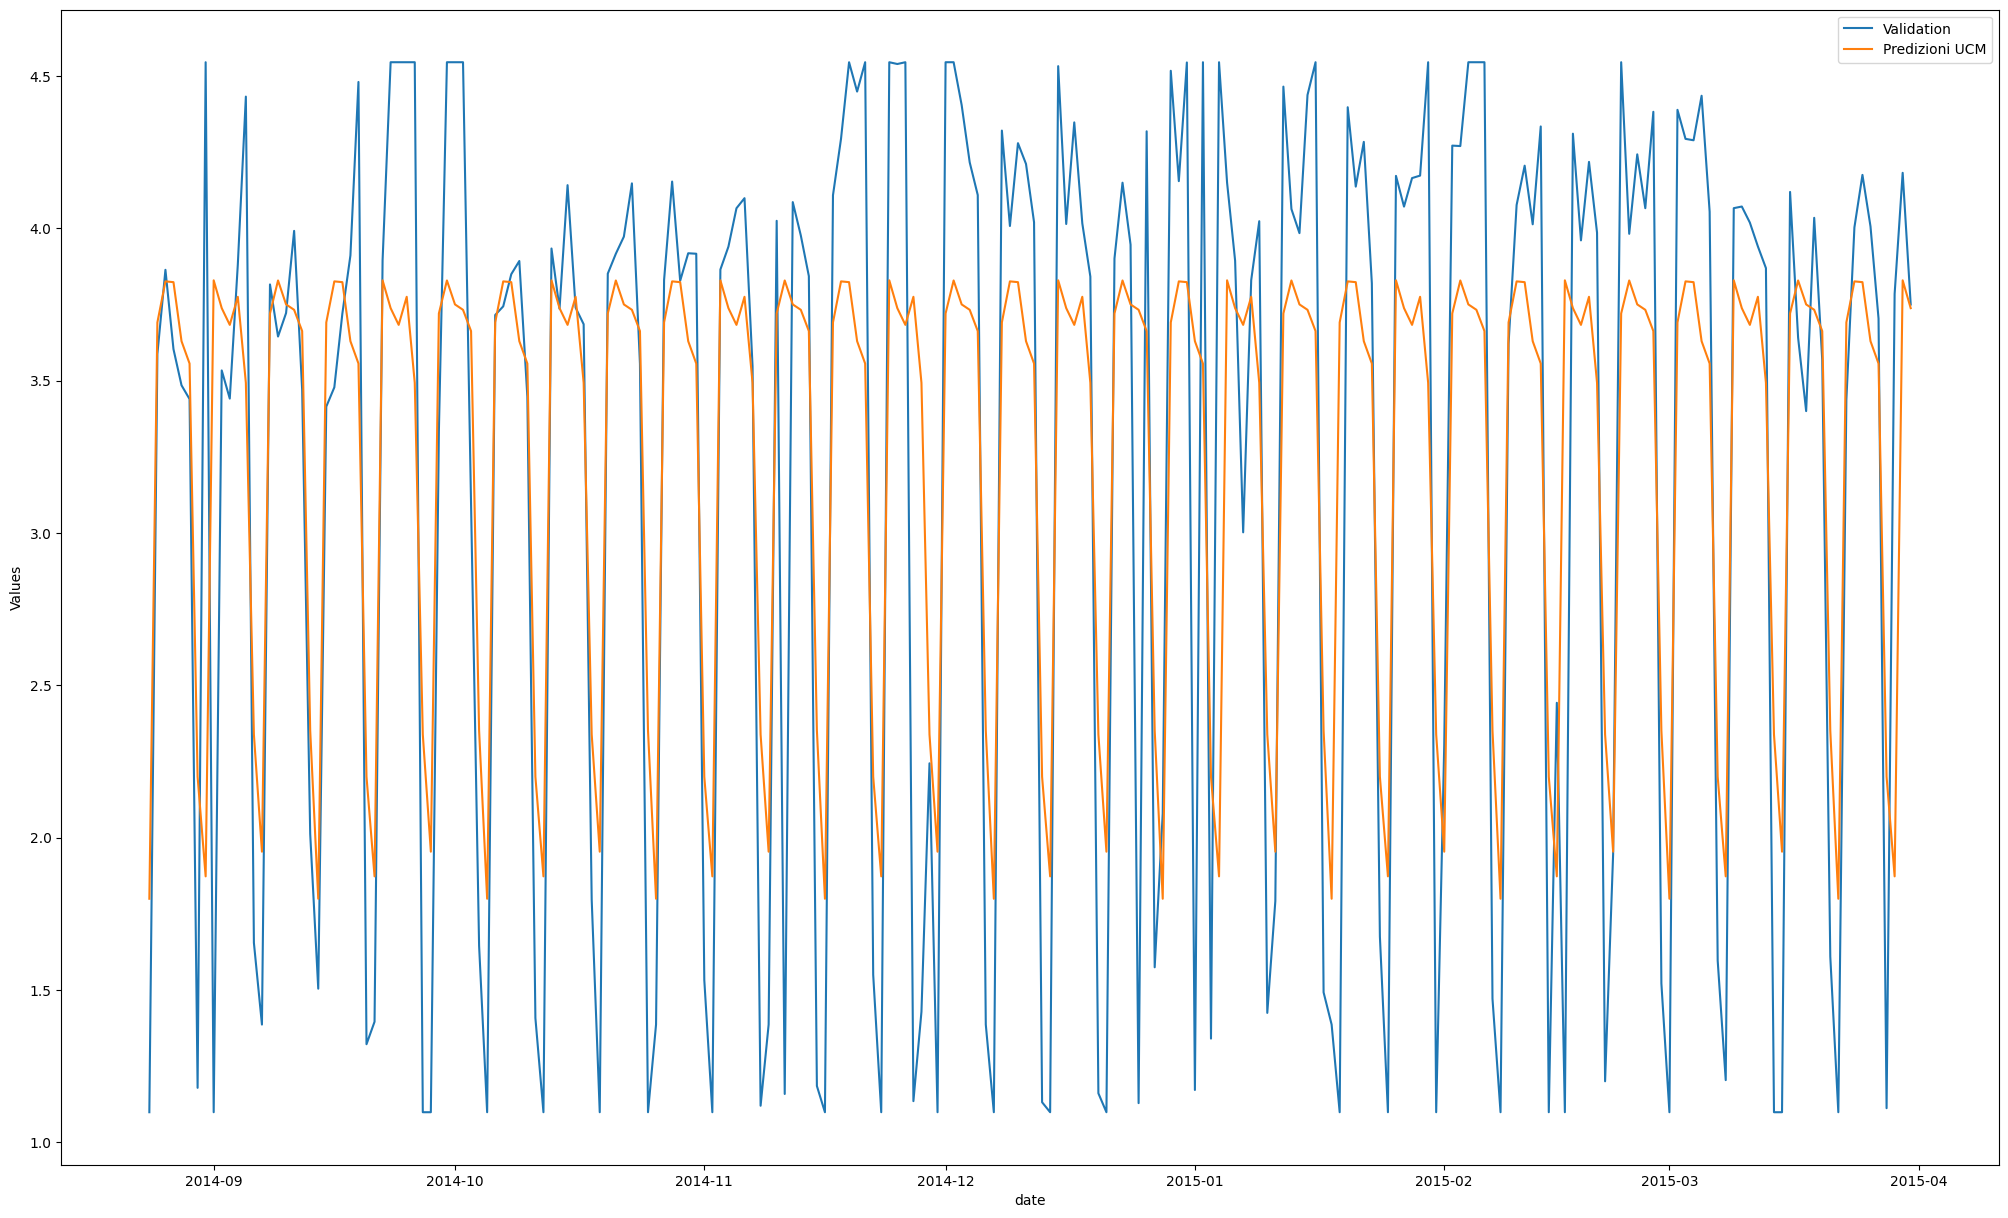

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(test.index, test, label='Validation')
plt.plot(test.index, predicted_mean, label='Predizioni UCM')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()

## Model 2 - Random Walk

In [ ]:
import statsmodels.api as sm

model2_UCM = sm.tsa.UnobservedComponents(train, 'rwalk', trend=True, seasonal=21, stochastic_level=False, stochastic_trend=True, stochastic_seasonal=True)

# Fit del modello
result2 = model2_UCM.fit()

# Stampa un riepilogo dei risultati
print(result2.summary())

# Valuta il modello sui dati di test
forecast = result2.get_forecast(steps=len(test))
predicted_mean2 = forecast.predicted_mean
rmse = np.sqrt(((predicted_mean2 - test) ** 2).mean())
print(f"RMSE sul set di test: {rmse}")


                            Unobserved Components Results                            
Dep. Variable:               ave_days_filled   No. Observations:                 2789
Model:                           random walk   Log Likelihood               -3918.518
                   + stochastic seasonal(21)   AIC                           7841.036
Date:                       Fri, 16 Feb 2024   BIC                           7852.888
Time:                               14:05:58   HQIC                          7845.316
Sample:                           01-04-2007                                         
                                - 08-23-2014                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level        0.2984      0.012     25.069      0.00

In [ ]:
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# Calcola le metriche
mae_ucm = mean_absolute_error(test, predicted_mean2)
mse_ucm = mean_squared_error(test, predicted_mean2)

# Stampa le metriche
print('UCM Metrics on Validation Set:')
print('MAE:', mae_ucm)
print('MSE:', mse_ucm)

UCM Metrics on Validation Set:
MAE: 1.0122429933665507
MSE: 1.8678844379272497


## Model 3 - Random Walk with Drift

In [ ]:
import statsmodels.api as sm


model3_UCM = sm.tsa.UnobservedComponents(train, 'rwdrift', trend=True, seasonal=7, stochastic_level=False, stochastic_trend=True, stochastic_seasonal=True)

# Fit del modello
result3 = model3_UCM.fit()

# Stampa un riepilogo dei risultati
print(result3.summary())

# Valuta il modello sui dati di test
forecast = result3.get_forecast(steps=len(test))
predicted_mean3 = forecast.predicted_mean
rmse = np.sqrt(((predicted_mean3 - test) ** 2).mean())
print(f"RMSE sul set di test: {rmse}")

                           Unobserved Components Results                            
Dep. Variable:              ave_days_filled   No. Observations:                 2789
Model:               random walk with drift   Log Likelihood               -3883.987
                   + stochastic seasonal(7)   AIC                           7771.973
Date:                      Fri, 16 Feb 2024   BIC                           7783.835
Time:                              13:59:49   HQIC                          7776.256
Sample:                          01-04-2007                                         
                               - 08-23-2014                                         
Covariance Type:                        opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level        0.2791      0.011     25.824      0.000       0

In [ ]:
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# Calcola le metriche
mae_ucm = mean_absolute_error(test, predicted_mean3)
mse_ucm = mean_squared_error(test, predicted_mean3)

# Stampa le metriche
print('UCM Metrics on Validation Set:')
print('MAE:', mae_ucm)
print('MSE:', mse_ucm)

UCM Metrics on Validation Set:
MAE: 0.883565830302315
MSE: 1.911385834742635


## Model 4 - Seasonal Trend

In [ ]:
import statsmodels.api as sm


model4_UCM = sm.tsa.UnobservedComponents(train, 'strend', trend=True, seasonal=7, stochastic_level=False, stochastic_trend=True, stochastic_seasonal=True)

# Fit del modello
result4 = model4_UCM.fit()

# Stampa un riepilogo dei risultati
print(result4.summary())

# Valuta il modello sui dati di test
forecast = result4.get_forecast(steps=len(test))
predicted_mean4 = forecast.predicted_mean
rmse = np.sqrt(((predicted_mean4 - test) ** 2).mean())
print(f"RMSE sul set di test: {rmse}")

                           Unobserved Components Results                            
Dep. Variable:              ave_days_filled   No. Observations:                 2789
Model:                         smooth trend   Log Likelihood               -3159.480
                   + stochastic seasonal(7)   AIC                           6324.959
Date:                      Fri, 16 Feb 2024   BIC                           6342.751
Time:                              13:48:27   HQIC                          6331.384
Sample:                          01-04-2007                                         
                               - 08-23-2014                                         
Covariance Type:                        opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.5203      0.009     57.980      0.000     

In [ ]:
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

# Calcola le metriche
mae_ucm = mean_absolute_error(test, predicted_mean4)
mse_ucm = mean_squared_error(test, predicted_mean4)

# Stampa le metriche
print('UCM Metrics on Validation Set:')
print('MAE:', mae_ucm)
print('MSE:', mse_ucm)

UCM Metrics on Validation Set:
MAE: 0.6374008376754826
MSE: 0.9013230496439658


### Forecast

In [ ]:
import statsmodels.api as sm
import pandas as pd

model_UCM = sm.tsa.UnobservedComponents(serie, 'llevel', trend=True, seasonal=21, stochastic_level=False, stochastic_trend=True, stochastic_seasonal=True)
result_UCM = model_UCM.fit()

# Specifica le date di inizio e fine per le previsioni
start_date = '2015-04-01'
end_date = '2015-11-07'

# Crea un indice temporale per il periodo di previsione
forecast_index = pd.date_range(start=start_date, end=end_date, freq='D')


forecast = result_UCM.get_forecast(steps=len(forecast_index))

# Estrai i valori previsti
predicted_mean = forecast.predicted_mean

# Crea un DataFrame con le previsioni
forecast_df_ucm = pd.DataFrame(data={'UCM': predicted_mean}, index=forecast_index)

# Visualizza il DataFrame con le previsioni
print(forecast_df_ucm)


                 UCM
2015-04-01  3.841071
2015-04-02  3.780637
2015-04-03  3.771946
2015-04-04  1.990346
2015-04-05  1.838972
...              ...
2015-11-03  3.809717
2015-11-04  3.916390
2015-11-05  3.811431
2015-11-06  3.929400
2015-11-07  2.059186

[221 rows x 1 columns]


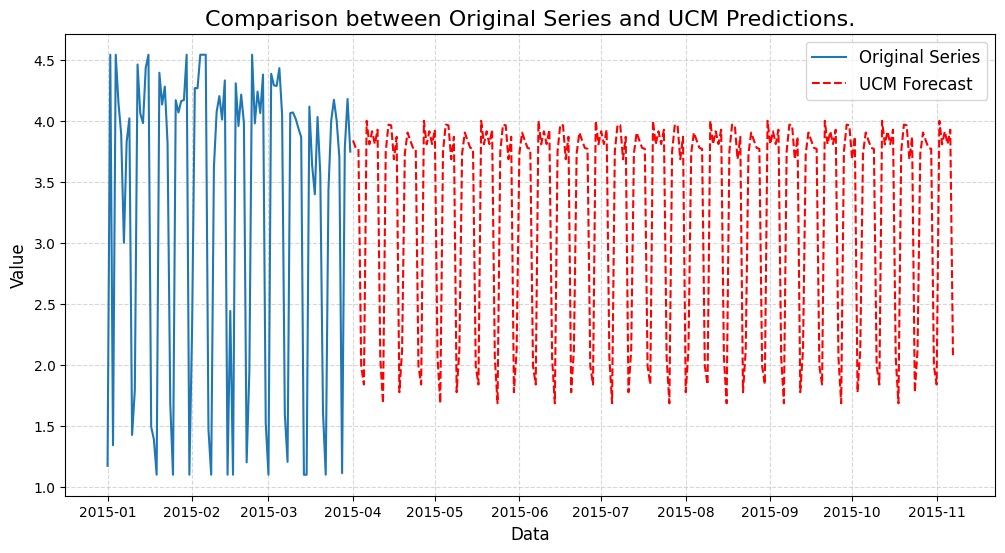

In [ ]:
import matplotlib.pyplot as plt

# Estrai gli ultimi 3 mesi della serie originale
last_3_months_original = serie_arima.index[-90:]
last_3_months_values = serie_arima[-90:]

# Unisci la serie originale con le previsioni del modello SARIMA
combined_df = pd.concat([last_3_months_values, forecast_df_ucm], axis=1)

# Plot della serie originale e delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df.iloc[:, 0], label='Original Series')
plt.plot(combined_df.index, combined_df.iloc[:, 1], label='UCM Forecast', color='red', linestyle='dashed')

# Imposta i titoli e le etichette degli assi
plt.title('Comparison between Original Series and UCM Predictions.', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Aggiungi una legenda
plt.legend(fontsize=12)

# Aggiungi una griglia
plt.grid(True, linestyle='--', alpha=0.5)

# Mostra il plot
plt.show()


# Unione tabelle

In [ ]:
UCM = pd.DataFrame(forecast_df_ucm.UCM,columns=['Date', 'UCM'])

In [ ]:
UCM['Date'] = UCM.index

In [ ]:
ARIMA = pd.DataFrame(forecast_df_sarima.ARIMA,columns=['Date', 'ARIMA'])
ARIMA['Date'] = ARIMA.index

In [ ]:
ML['Date'] = ML.index

In [ ]:
ML = ML.rename(columns = {'Predicted_Values': 'ML'})

In [ ]:
ML.

In [ ]:
UCM

In [ ]:
UCM['UCM'] = np.exp(UCM['UCM'])

In [ ]:
ARIMA['ARIMA'] = np.exp(ARIMA['ARIMA'])

In [ ]:
import pandas as pd
# Merging DataFrames
Forecast_Sinanaj_844540 = pd.merge(pd.merge(ML, ARIMA, on='Date'), UCM, on='Date')


In [ ]:
Forecast_Sinanaj_844540

ML       Date      ARIMA        UCM
0    35.996541 2015-04-01  55.251960  46.575328
1    34.939122 2015-04-02  53.001156  43.843974
2    33.058626 2015-04-03  50.958564  43.464552
3     4.864693 2015-04-04   4.933318   7.318063
4     4.727924 2015-04-05   6.246625   6.290066
..         ...        ...        ...        ...
216  46.722197 2015-11-03  63.941030  45.137666
217  46.525104 2015-11-04  68.097102  50.218812
218  46.462533 2015-11-05  55.775717  45.215085
219  43.302569 2015-11-06  60.254933  50.876439
220   6.154253 2015-11-07   5.252672   7.839589

[221 rows x 4 columns]

In [ ]:
# Swap the order of columns 'ML' and 'Date'
Forecast_Sinanaj_844540 = Forecast_Sinanaj_844540.reindex(columns=[ 'Date','ML', 'ARIMA', 'UCM'])


In [ ]:
Forecast_Sinanaj_844540

Date         ML      ARIMA        UCM
0   2015-04-01  35.996541  55.251960  46.575328
1   2015-04-02  34.939122  53.001156  43.843974
2   2015-04-03  33.058626  50.958564  43.464552
3   2015-04-04   4.864693   4.933318   7.318063
4   2015-04-05   4.727924   6.246625   6.290066
..         ...        ...        ...        ...
216 2015-11-03  46.722197  63.941030  45.137666
217 2015-11-04  46.525104  68.097102  50.218812
218 2015-11-05  46.462533  55.775717  45.215085
219 2015-11-06  43.302569  60.254933  50.876439
220 2015-11-07   6.154253   5.252672   7.839589

[221 rows x 4 columns]

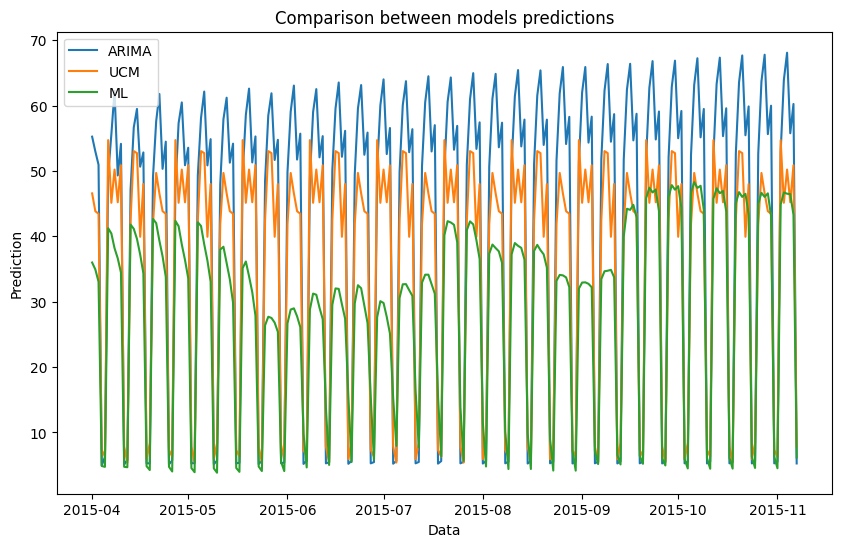

In [ ]:
# Convertire la colonna 'Date' in formato datetime
Forecast_Sinanaj_844540['Date'] = pd.to_datetime(Forecast_Sinanaj_844540['Date'])

# Impostare la colonna 'Date' come indice
Forecast_Sinanaj_844540.set_index('Date', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Forecast_Sinanaj_844540.index, Forecast_Sinanaj_844540['ARIMA'], label='ARIMA')
plt.plot(Forecast_Sinanaj_844540.index, Forecast_Sinanaj_844540['UCM'], label='UCM')
plt.plot(Forecast_Sinanaj_844540.index, Forecast_Sinanaj_844540['ML'], label='ML')

# Aggiungere titoli e legenda
plt.title('Comparison between models predictions')
plt.xlabel('Data')
plt.ylabel('Prediction')
plt.legend()

# Mostrare il grafico
plt.show()

In [ ]:
Forecast_Sinanaj_844540.reset_index(inplace=True)
Forecast_Sinanaj_844540.to_csv('/content/drive/MyDrive/TSA/844540_20240217.csv')


In [ ]:
Forecast_Sinanaj_844540.drop(columns=['level_0','index'], inplace = True)
Forecast_Sinanaj_844540

Date         ML      ARIMA        UCM
0   2015-04-01  35.996541  55.251960  46.575328
1   2015-04-02  34.939122  53.001156  43.843974
2   2015-04-03  33.058626  50.958564  43.464552
3   2015-04-04   4.864693   4.933318   7.318063
4   2015-04-05   4.727924   6.246625   6.290066
..         ...        ...        ...        ...
216 2015-11-03  46.722197  63.941030  45.137666
217 2015-11-04  46.525104  68.097102  50.218812
218 2015-11-05  46.462533  55.775717  45.215085
219 2015-11-06  43.302569  60.254933  50.876439
220 2015-11-07   6.154253   5.252672   7.839589

[221 rows x 4 columns]

In [ ]:
Forecast_Sinanaj_844540.to_csv('/content/drive/MyDrive/TSA/844540_20240217.csv')

In [ ]:
Forecast_Sinanaj_844540

Date         ML      ARIMA        UCM
0   2015-04-01  35.996541  55.251960  46.575328
1   2015-04-02  34.939122  53.001156  43.843974
2   2015-04-03  33.058626  50.958564  43.464552
3   2015-04-04   4.864693   4.933318   7.318063
4   2015-04-05   4.727924   6.246625   6.290066
..         ...        ...        ...        ...
216 2015-11-03  46.722197  63.941030  45.137666
217 2015-11-04  46.525104  68.097102  50.218812
218 2015-11-05  46.462533  55.775717  45.215085
219 2015-11-06  43.302569  60.254933  50.876439
220 2015-11-07   6.154253   5.252672   7.839589

[221 rows x 4 columns]